### Prerequisites

In [2]:
from datetime import datetime,timedelta
import matplotlib.pyplot as plt
import pandas as pd
import sqlalchemy
import yaml

# Get current data
Quality check quantaties per week in Haldesleben, per product category to check and by check type for Otto and Bon Prix.

So a little more comprehensive. The dimensions of the data are:
- Time: weeks
- Company (BDF): Otto or Bon Prix
- Product category (WP_Bereich): Deko,Hartware, Schmuck, Schuhe, Textil




### Define parameters

In [3]:
# Load the yamls Config and parameters
config_path = "../../models/configs/config_bdf_sortiment.yml"
with open(config_path, 'r') as file:
        config = yaml.safe_load(file)
with open('../../models/configs/config_parameters.yml', 'r') as file:
    parameters = yaml.safe_load(file)


# SQL Parameters    
mssql_server='hfdmmart'
mssql_database='TM1_SCHNITTSTELLE'
mssql_username='FKT_APOLLO_SPSS'
mssql_password='S4nKTlMRkrvkL-U3LIFbc_9Zl-Ek3f'
connection_string = f"DRIVER={{ODBC Driver 17 for SQL Server}}; SERVER={mssql_server}; DATABASE={mssql_database}; UID={mssql_username}; PWD={mssql_password}"
connection_url = sqlalchemy.URL.create("mssql+pyodbc", query={"odbc_connect": connection_string})

# Save settings from configuration file
columns = config['data_series']
target_columns = config['target_columns']
naming = config['naming']
setback = parameters['setback']

# Calculate cutoff date to create observation period of 3 years
current_date = datetime.now()
cutoff_num = config['cutoff_num'] # 3 so three years cutoff 
cutoff_date = current_date - timedelta(days=cutoff_num*365)

### Get data from SQL
VPN access is required to access the database

In [4]:
# Build SQL query
kennzahl = 'Warenprüfung'
sql_query = f" SELECT [Tag], [Pruefschaerfe], [BDF], [WP_Bereich], [Kennzahl], [Wert] FROM [TM1_SCHNITTSTELLE].[EXPORT].[Analytics_Lieferscheinmenge] WHERE CAST([Kennzahl] AS VARCHAR(MAX)) = '{kennzahl}'"

# Execute query to download data
engine = sqlalchemy.create_engine(connection_url)
with engine.begin() as conn:
    raw_data = pd.read_sql_query(sqlalchemy.text(sql_query), conn)
engine.dispose()

# Print data for visual validation
raw_data


Tag        Pruefschaerfe       BDF WP_Bereich      Kennzahl  \
0      2022-10-07  T - Prüfen (1 Teil)  BON PRIX     Textil  Warenprüfung   
1      2022-09-16  T - Prüfen (1 Teil)  BON PRIX     Textil  Warenprüfung   
2      2022-09-13  T - Prüfen (1 Teil)  BON PRIX     Textil  Warenprüfung   
3      2022-09-21  T - Prüfen (1 Teil)  BON PRIX     Textil  Warenprüfung   
4      2022-05-19  T - Prüfen (1 Teil)  BON PRIX     Schuhe  Warenprüfung   
...           ...                  ...       ...        ...           ...   
18943  2024-06-21    K - keine Prüfung      OTTO    Schmuck  Warenprüfung   
18944  2024-06-26    K - keine Prüfung      OTTO    Schmuck  Warenprüfung   
18945  2024-06-27    K - keine Prüfung      OTTO    Schmuck  Warenprüfung   
18946  2024-06-28    K - keine Prüfung      OTTO   Hartware  Warenprüfung   
18947  2024-06-19    K - keine Prüfung      OTTO     Schuhe  Warenprüfung   

        Wert  
0       41.0  
1      124.0  
2       65.0  
3       70.0  
4       16.0  
...      ...  
18943    NaN  
18944    NaN  
18945    NaN  
18946    NaN  
18947    NaN  

[18948 rows x 6 columns]

### Prepare data

In [5]:
# Change column types, to datetime and numeric
df_wp_ist = raw_data.copy()
df_wp_ist["Tag"] = pd.to_datetime(df_wp_ist["Tag"])
df_wp_ist.set_index("Tag", inplace=True)
df_wp_ist["Wert"] = pd.to_numeric(df_wp_ist["Wert"], errors='coerce')
df_wp_ist = df_wp_ist.sort_values("Tag")

# Drop unknown WP_Bereich
df_wp_ist = df_wp_ist.query("(BDF == 'OTTO' or BDF == 'BON PRIX') and WP_Bereich != 'Unbekannt'")

# Apply cutoff date
df_wp_ist = df_wp_ist[df_wp_ist.index >= cutoff_date].reset_index()

# Sum up Pruefschaerfe
df_wp_ist = df_wp_ist.pivot_table(index='Tag', columns= target_columns,values='Wert', aggfunc='sum')
df_wp_ist.fillna(0, inplace=True)

# Sum up per week
df_wp_ist_week = df_wp_ist.resample('W', label='left').sum()
# Resample sums up to the first day of the US American calender (Sunday), for German standards the week starts on Monday
df_wp_ist_week.index = df_wp_ist_week.index + pd.DateOffset(days=1)

# Remove empty rows with just 0 in them
df_wp_ist_week = df_wp_ist_week[(df_wp_ist_week != 0).any(axis=1)]

# Print out the dataframe
df_wp_ist_week

BDF        BON PRIX                                   OTTO                   \
WP_Bereich     Deko Hartware Schmuck Schuhe  Textil   Deko Hartware Schmuck   
Tag                                                                           
2022-02-28    640.0     44.0     4.0  350.0  3399.0  371.0   1443.0    82.0   
2022-03-07    634.0    140.0     3.0  133.0  4515.0  486.0   2142.0     0.0   
2022-03-14    349.0    177.0    22.0  749.0  4268.0  160.0   1692.0    43.0   
2022-03-21    299.0     43.0     1.0  439.0  4855.0  398.0   2003.0    10.0   
2022-03-28    899.0    112.0     0.0  874.0  7240.0  395.0   2050.0    38.0   
...             ...      ...     ...    ...     ...    ...      ...     ...   
2024-11-18      1.0     73.0    20.0  208.0  2198.0  718.0   2308.0  1693.0   
2024-11-25     77.0     78.0    44.0  105.0  4572.0  170.0   2095.0  1716.0   
2024-12-02     83.0      5.0     0.0  353.0  3182.0  350.0   2616.0  1467.0   
2024-12-09     39.0      1.0    48.0  465.0  4296.0  263.0   2788.0  1889.0   
2024-12-16     10.0      0.0     0.0    0.0   103.0  134.0    410.0   262.0   

BDF                         
WP_Bereich  Schuhe  Textil  
Tag                         
2022-02-28  1400.0  5898.0  
2022-03-07  1839.0  6180.0  
2022-03-14  1612.0  5059.0  
2022-03-21  2393.0  4769.0  
2022-03-28  1798.0  6725.0  
...            ...     ...  
2024-11-18  1370.0  3684.0  
2024-11-25  1144.0  4396.0  
2024-12-02   883.0  2956.0  
2024-12-09  1059.0  3053.0  
2024-12-16    84.0   755.0  

[147 rows x 10 columns]

In [5]:
# Slice dataframes in two, by company, just for easier handling below
otto_quantities = df_wp_ist_week.iloc[:,5:]
bon_prix_quantities = df_wp_ist_week.iloc[:,:5]

# Define plotting functions

In [6]:
def lineplots(data, title_name):
    # Create a line plot
    plt.figure(figsize=(20, 6))
    for column in data.columns:
        plt.plot(data.index, data[column], marker='o', label=str(column))

    # Adding labels and title
    plt.title(f"{title_name}")
    plt.xlabel('Time')
    plt.ylabel('Quantities')
    plt.legend(loc='best')

    # Show the plot
    plt.show()

In [7]:
def stackplotting(data, title_name):
    # Create a stack plot
    plt.figure(figsize=(20, 6))
    plt.stackplot(data.index, data.T, labels=data.columns)

    # Adding labels and title
    plt.title(f"{title_name}")
    plt.xlabel('Time')
    plt.ylabel('Share of daily quantities in %')
    plt.legend(loc='upper right')

    # Show the plot
    plt.show()

In [34]:
def histogram_plot(data, title_name):
    # Calculate the row-to-row changes
    df_changes = data.diff().dropna()  # Drop the first row with NaN values

    # Create a histogram for the row-to-row changes
    plt.figure(figsize=(10, 6))
    for column in df_changes.columns:
        plt.hist(df_changes[column], bins=5, alpha=0.5, label=str(column))

    # Adding labels and title
    plt.title(title_name)
    plt.xlabel('Change of quantity')
    plt.ylabel('Frequency')

    # Automatically place the legend
    plt.legend(loc='best')

    # Show the plot
    plt.show()

In [8]:
def stackplotting_percentage(data, title_name):
    # Calculate the percentage of each row
    data_percentage = data.div(data.sum(axis=1), axis=0) * 100

    # Create a stack plot
    plt.figure(figsize=(20, 6))
    plt.stackplot(data_percentage.index, data_percentage.T, labels=data_percentage.columns)

    # Adding labels and title
    plt.title(f"{title_name}")
    plt.xlabel('Time')
    plt.ylabel('Share of daily quantities in %')
    plt.legend(loc='upper right')

    # Show the plot
    plt.show()

In [35]:
def plot_all(data,company_name):
    lineplots(data = data, title_name = f"{company_name}: Quantities inspected by type per week")
    stackplotting(data = data, title_name = f"{company_name}: Stacked quantities inspected by type per week")
    histogram_plot(data = data, title_name = f"{company_name}: Histogram of week-to-week Changes for Each product Category")
    lineplots(data = data.diff(), title_name = f"{company_name}: Changes of quantities inspected by type per week")
    stackplotting_percentage(data, title_name= f"{company_name}: Share of quantities inspected by type per week ")

# Otto plots

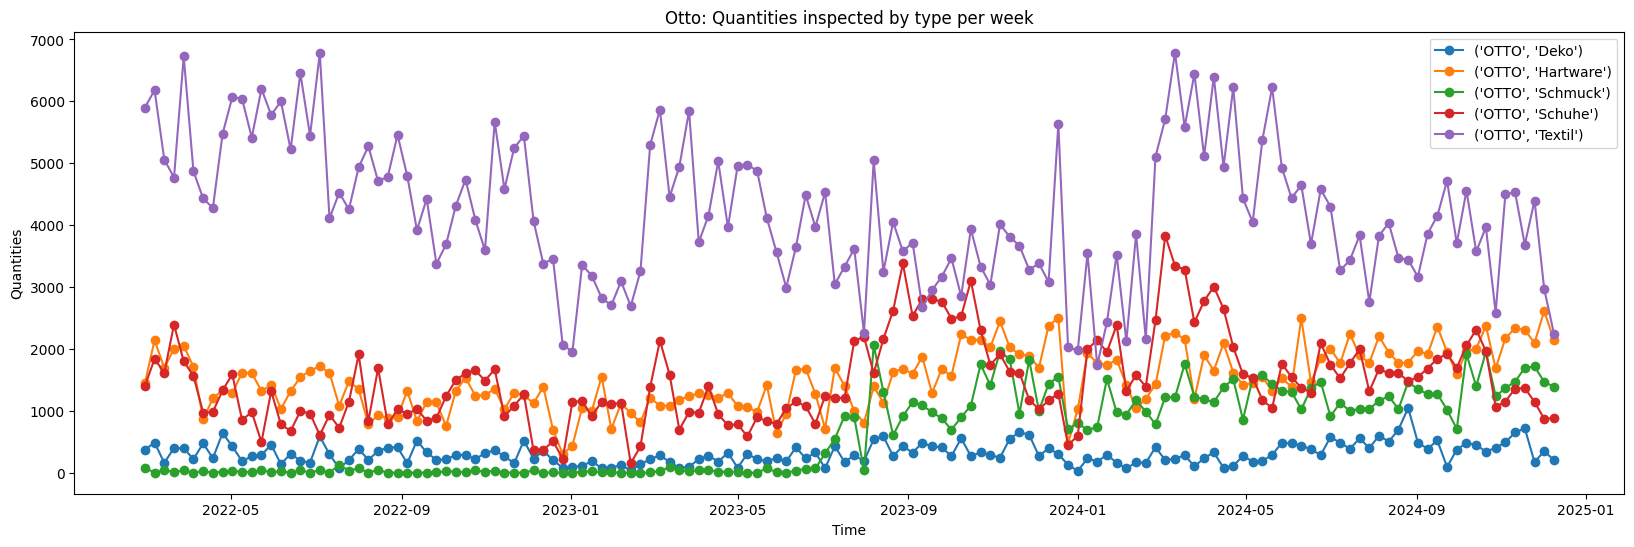

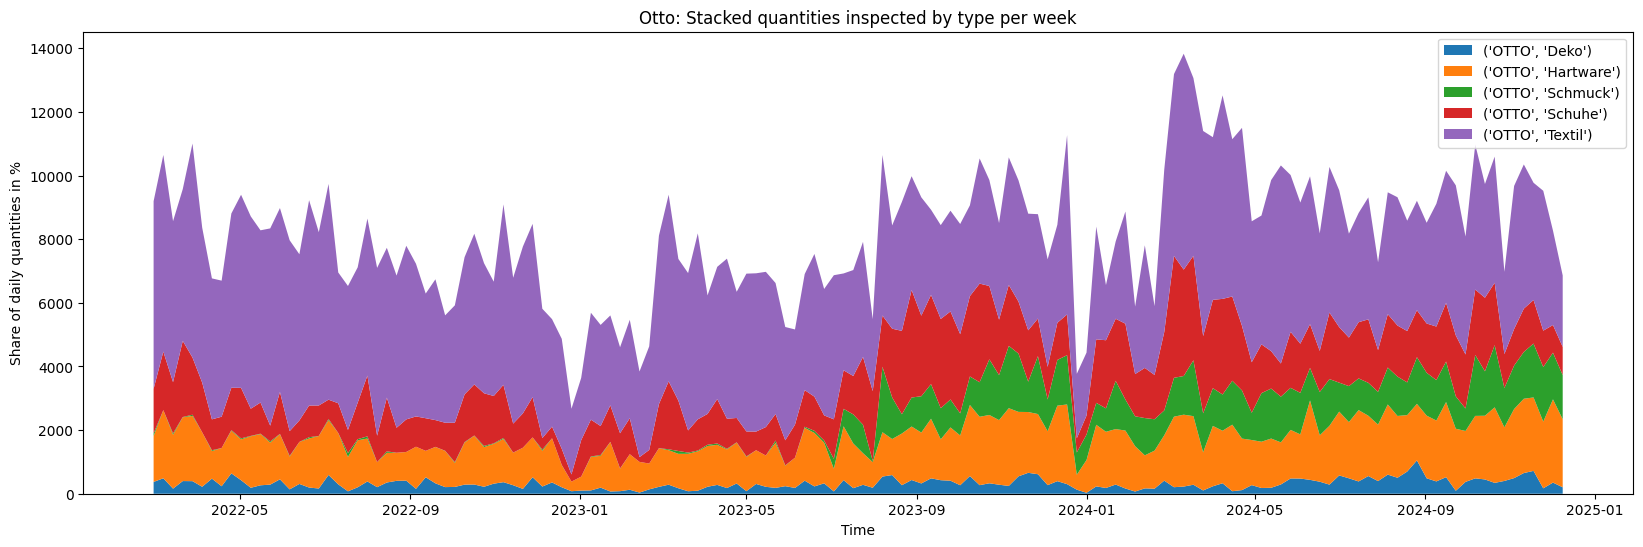

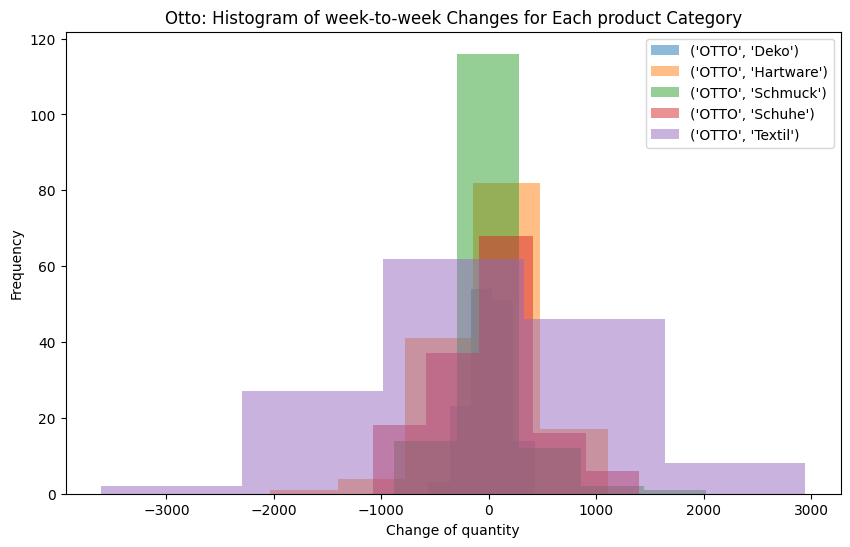

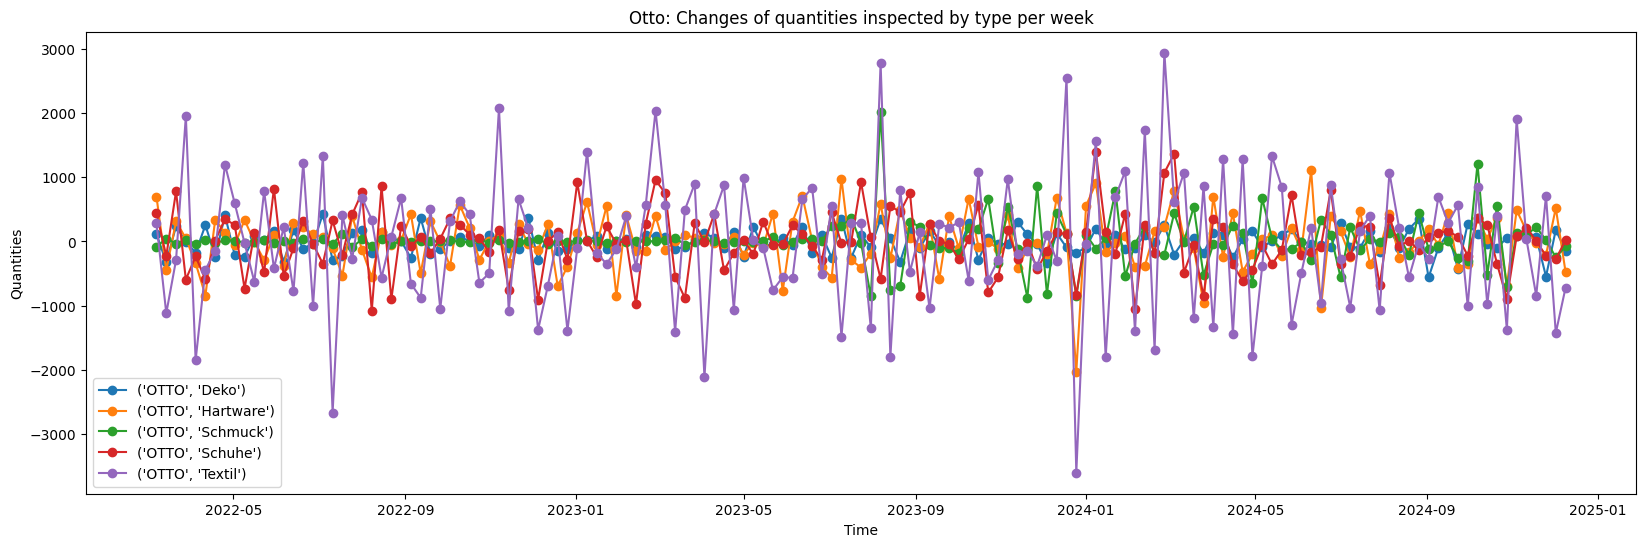

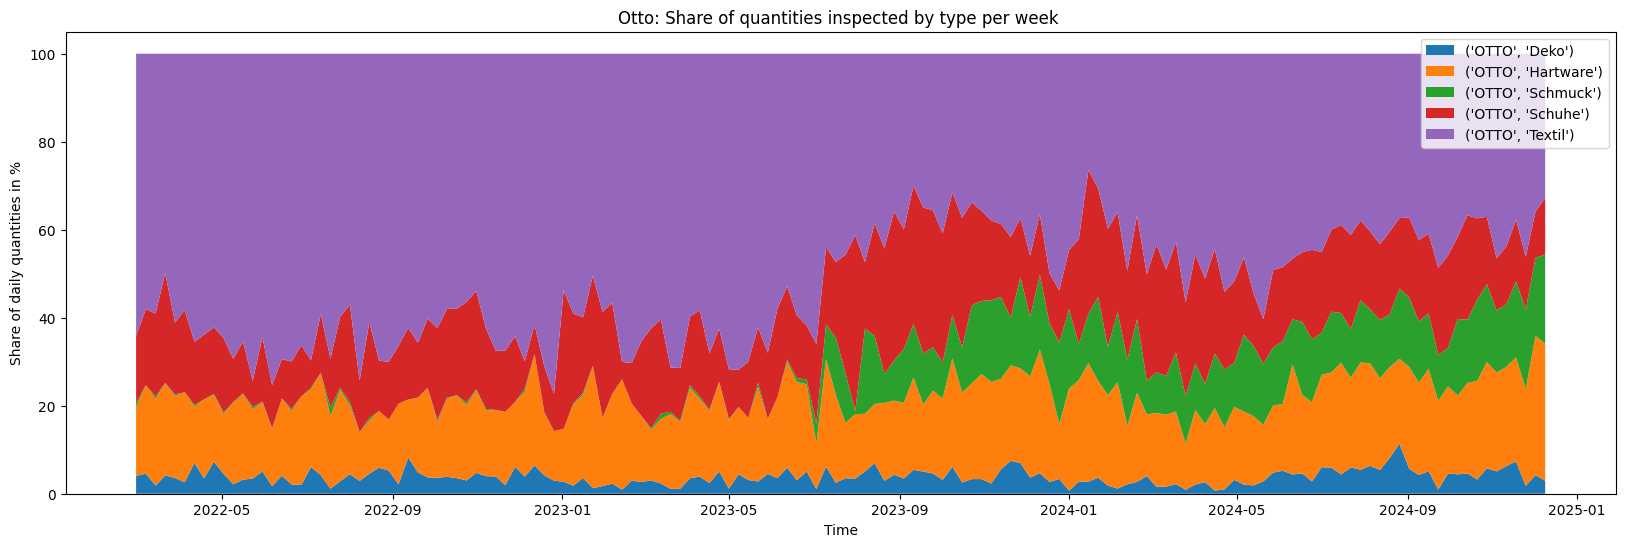

In [36]:
plot_all(data = otto_quantities, company_name = "Otto")

# Bon Prix

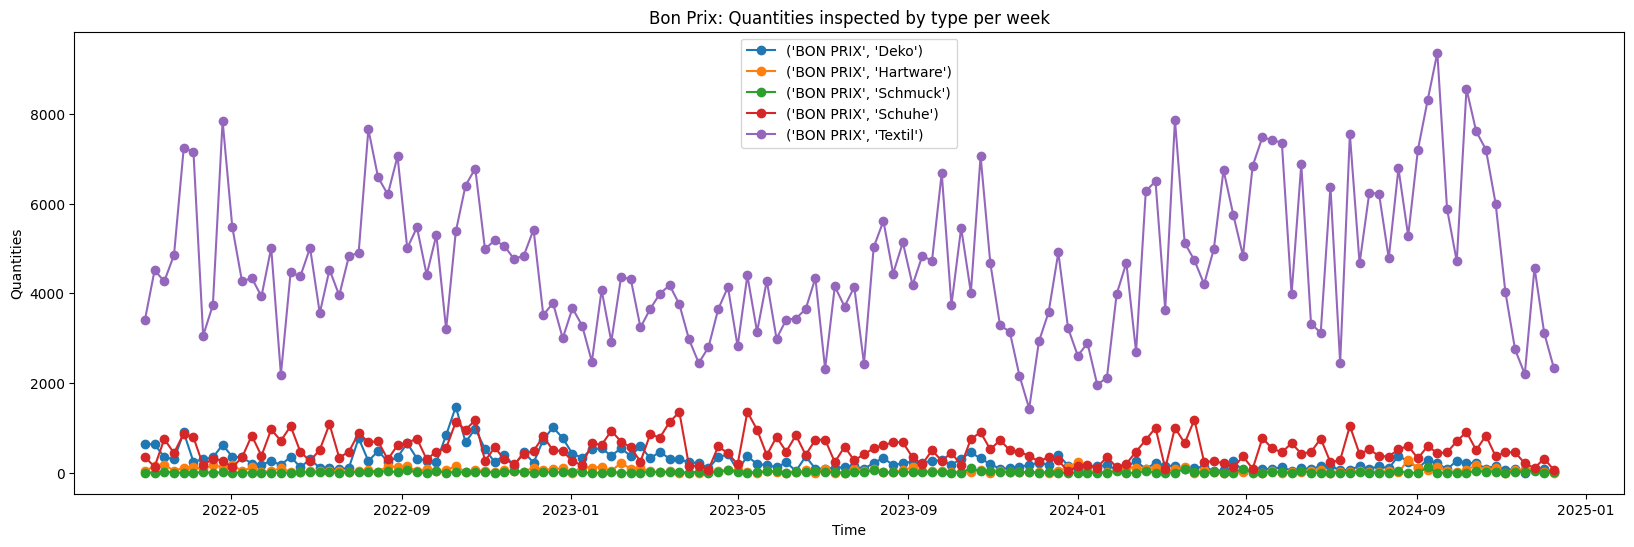

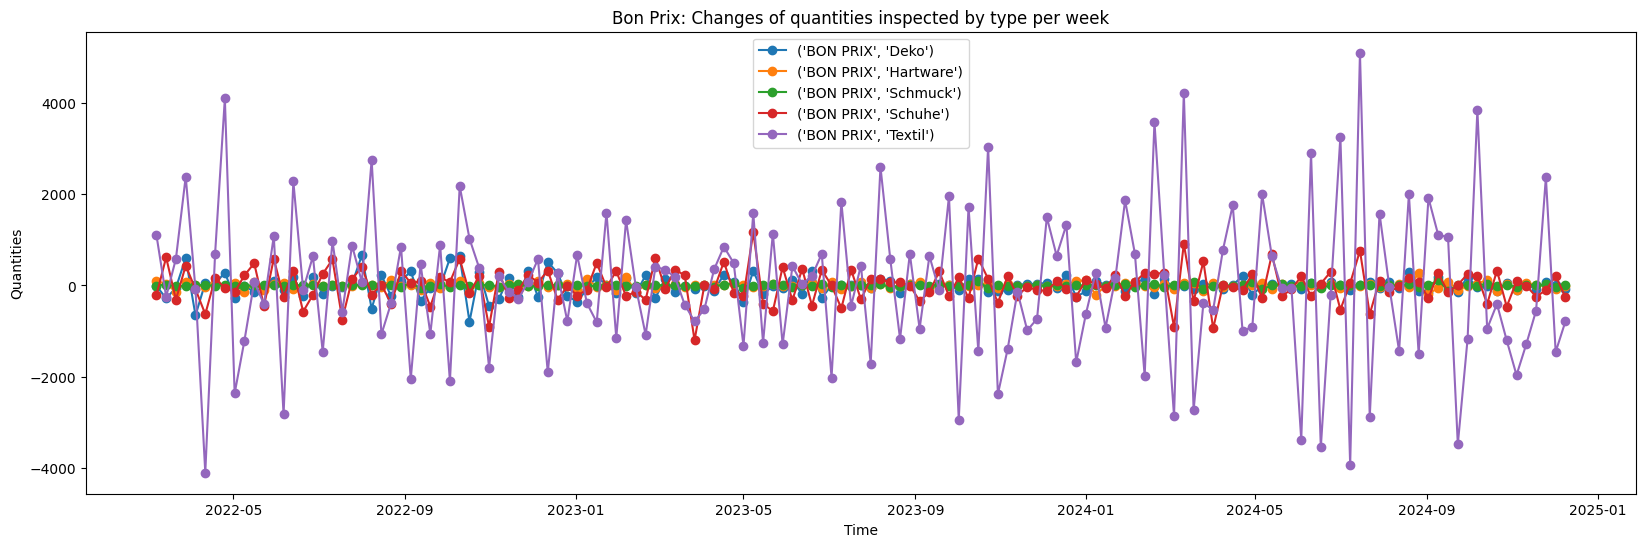

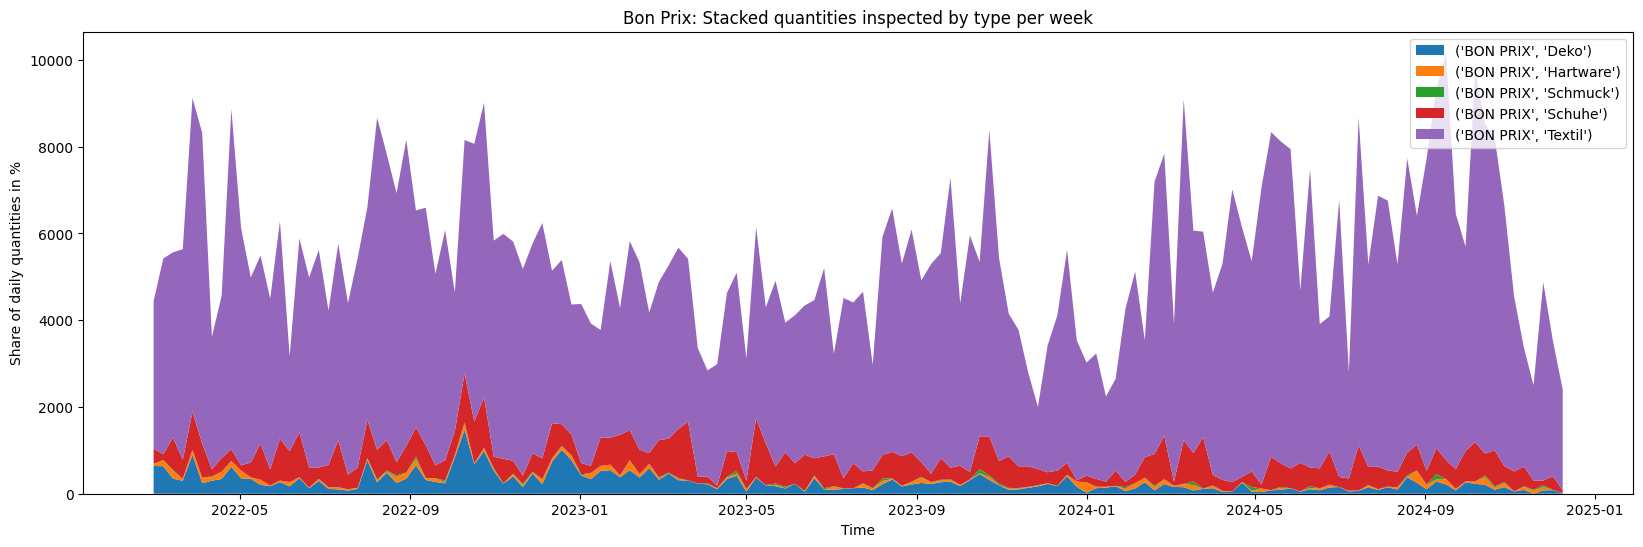

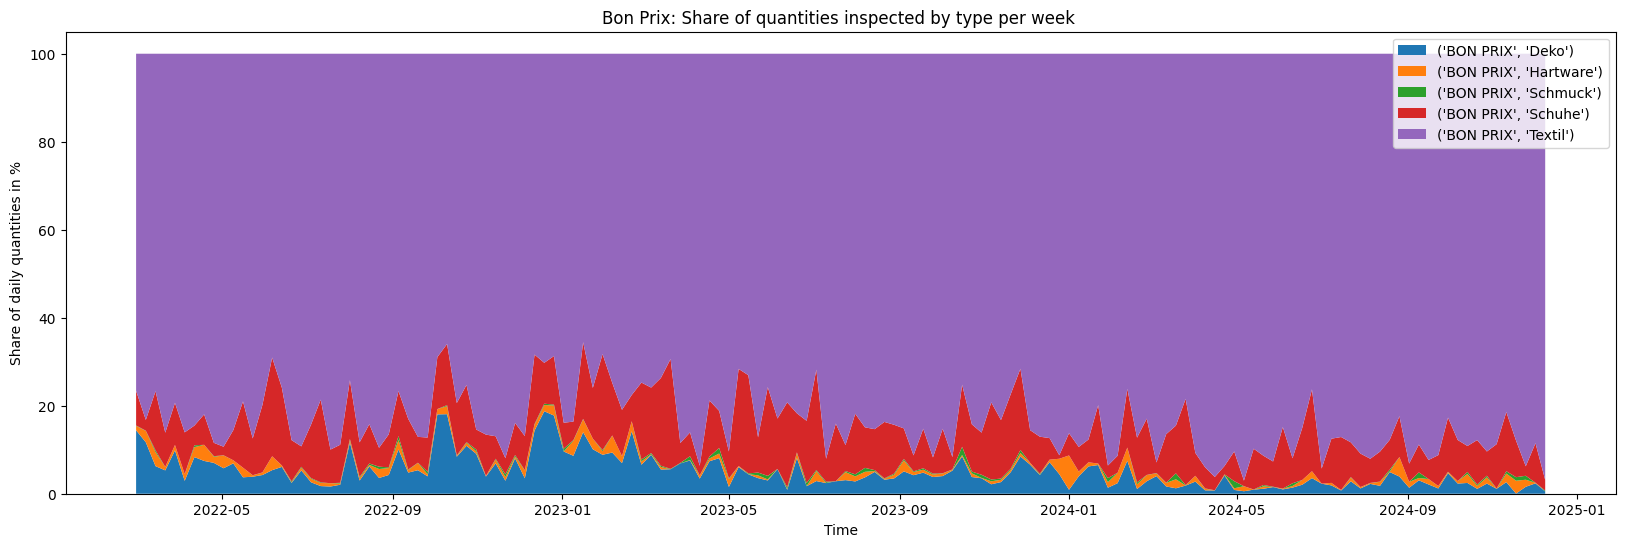

In [27]:
plot_all(data=bon_prix_quantities, company_name="Bon Prix")


In [2]:
!pip install openpyxl
!pip install pmdarima
!pip install seaborn



In [7]:
!pip install tensorflow

   ---------------------------------------- 0.0/390.0 MB ? eta -:--:--
   ---------------------------------------- 0.3/390.0 MB ? eta -:--:--
   ---------------------------------------- 0.8/390.0 MB 2.6 MB/s eta 0:02:31
   ---------------------------------------- 1.6/390.0 MB 2.5 MB/s eta 0:02:33
   ---------------------------------------- 1.8/390.0 MB 2.5 MB/s eta 0:02:39
   ---------------------------------------- 2.4/390.0 MB 2.4 MB/s eta 0:02:39
   ---------------------------------------- 2.9/390.0 MB 2.5 MB/s eta 0:02:37
   ---------------------------------------- 3.1/390.0 MB 2.5 MB/s eta 0:02:38
   ---------------------------------------- 3.1/390.0 MB 2.5 MB/s eta 0:02:38
   ---------------------------------------- 3.4/390.0 MB 1.9 MB/s eta 0:03:26
   ---------------------------------------- 4.5/390.0 MB 2.1 MB/s eta 0:03:03
    --------------------------------------- 5.2/390.0 MB 2.3 MB/s eta 0:02:47
    --------------------------------------- 6.3/390.0 MB 2.5 MB/s eta 0:02:33


ERROR: Could not install packages due to an OSError: [WinError 32] Der Prozess kann nicht auf die Datei zugreifen, da sie von einem anderen Prozess verwendet wird: 'C:\\Users\\MASRAR\\.venvs\\forecast-warenpruefung-dRZq0wLU-py3.10\\Lib\\site-packages\\clang\\__init__.py'
Check the permissions.



  Using cached tensorflow-2.18.0-cp310-cp310-win_amd64.whl.metadata (3.3 kB)
  Using cached tensorflow_intel-2.18.0-cp310-cp310-win_amd64.whl.metadata (4.9 kB)
  Using cached absl_py-2.1.0-py3-none-any.whl.metadata (2.3 kB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl.metadata (4.4 kB)
  Using cached flatbuffers-24.12.23-py2.py3-none-any.whl.metadata (876 bytes)
  Using cached gast-0.6.0-py3-none-any.whl.metadata (1.3 kB)
  Using cached google_pasta-0.2.0-py3-none-any.whl.metadata (814 bytes)
  Using cached libclang-18.1.1-py2.py3-none-win_amd64.whl.metadata (5.3 kB)
  Using cached opt_einsum-3.4.0-py3-none-any.whl.metadata (6.3 kB)
  Using cached protobuf-5.29.3-cp310-abi3-win_amd64.whl.metadata (592 bytes)
  Using cached termcolor-2.5.0-py3-none-any.whl.metadata (6.1 kB)
  Using cached wrapt-1.17.1-cp310-cp310-win_amd64.whl.metadata (6.5 kB)
  Using cached grpcio-1.69.0-cp310-cp310-win_amd64.whl.metadata (4.0 kB)
  Using cached tensorboard-2.18.0-py3-none-any.whl.metadata (1.

In [7]:
import os
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import sqlalchemy
import yaml
import openpyxl
import pmdarima as pm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from prophet import Prophet
import pickle
import xgboost as xgb
from sklearn.model_selection import train_test_split
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf 
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler

In [5]:

# Load Configurations
config_path = "../../models/configs/config_bdf_sortiment.yml"
with open(config_path, 'r') as file:
    config = yaml.safe_load(file)
naming = config['naming']   
with open('../../models/configs/config_parameters.yml', 'r') as file:
    parameters = yaml.safe_load(file)
    
    
best_hyperparameters_regressor_path = f"../../models/hyperparameters/best_hyperparameters_prediction_{naming}.pkl"
with open(best_hyperparameters_regressor_path, "rb") as file:
    best_hyperparameters_regressor_dict = pickle.load(file)    

# Database Connection Parameters
mssql_server = 'hfdmmart'
mssql_database = 'TM1_SCHNITTSTELLE'
mssql_username = 'FKT_APOLLO_SPSS'
mssql_password = 'S4nKTlMRkrvkL-U3LIFbc_9Zl-Ek3f'
connection_string = f"DRIVER={{ODBC Driver 17 for SQL Server}}; SERVER={mssql_server}; DATABASE={mssql_database}; UID={mssql_username}; PWD={mssql_password}"
connection_url = sqlalchemy.URL.create("mssql+pyodbc", query={"odbc_connect": connection_string})

# Connect and Query Data
kennzahl = 'Warenprüfung'
sql_query = f"""
    SELECT [Tag], [Pruefschaerfe], [BDF], [WP_Bereich], [Kennzahl], [Wert] 
    FROM [TM1_SCHNITTSTELLE].[EXPORT].[Analytics_Lieferscheinmenge]
    WHERE CAST([Kennzahl] AS VARCHAR(MAX)) = '{kennzahl}'
"""

engine = sqlalchemy.create_engine(connection_url)
with engine.begin() as conn:
    raw_data = pd.read_sql_query(sqlalchemy.text(sql_query), conn)
engine.dispose()

# Prepare Data
cutoff_num = config['cutoff_num']  # Example: 3 years
cutoff_date = datetime.now() - timedelta(days=cutoff_num * 365)

df_wp_ist = raw_data.copy()
df_wp_ist["Tag"] = pd.to_datetime(df_wp_ist["Tag"])
df_wp_ist.set_index("Tag", inplace=True)
df_wp_ist["Wert"] = pd.to_numeric(df_wp_ist["Wert"], errors='coerce')
df_wp_ist = df_wp_ist.sort_values("Tag")

df_wp_ist = df_wp_ist.query("(BDF == 'OTTO' or BDF == 'BON PRIX') and WP_Bereich != 'Unbekannt'")
df_wp_ist = df_wp_ist[df_wp_ist.index >= cutoff_date].reset_index()

# Pivot and Resample Data
df_wp_ist = df_wp_ist.pivot_table(index='Tag', columns=['BDF', 'WP_Bereich'], values='Wert', aggfunc='sum')
df_wp_ist.fillna(0, inplace=True)

df_wp_ist_week = df_wp_ist.resample('W', label='left').sum()
df_wp_ist_week.index = df_wp_ist_week.index + pd.DateOffset(days=1)
df_wp_ist_week = df_wp_ist_week[(df_wp_ist_week != 0).any(axis=1)]

df_wp_ist_week






BDF        BON PRIX                                   OTTO                   \
WP_Bereich     Deko Hartware Schmuck Schuhe  Textil   Deko Hartware Schmuck   
Tag                                                                           
2022-02-28    640.0     44.0     4.0  350.0  3399.0  371.0   1443.0    82.0   
2022-03-07    634.0    140.0     3.0  133.0  4515.0  486.0   2142.0     0.0   
2022-03-14    349.0    177.0    22.0  749.0  4268.0  160.0   1692.0    43.0   
2022-03-21    299.0     43.0     1.0  439.0  4855.0  398.0   2003.0    10.0   
2022-03-28    899.0    112.0     0.0  874.0  7240.0  395.0   2050.0    38.0   
...             ...      ...     ...    ...     ...    ...      ...     ...   
2024-12-16    306.0     16.0     3.0    8.0  6476.0  517.0   2377.0  1318.0   
2024-12-23     98.0     69.0    12.0   31.0  2988.0  116.0    573.0   204.0   
2024-12-30     71.0      2.0    13.0  290.0  6638.0   70.0    900.0   415.0   
2025-01-06    412.0     48.0    43.0  277.0  6573.0  162.0   1834.0   610.0   
2025-01-13     78.0    219.0    31.0  318.0  7253.0  285.0   2353.0   610.0   

BDF                         
WP_Bereich  Schuhe  Textil  
Tag                         
2022-02-28  1400.0  5898.0  
2022-03-07  1839.0  6180.0  
2022-03-14  1612.0  5059.0  
2022-03-21  2393.0  4769.0  
2022-03-28  1798.0  6725.0  
...            ...     ...  
2024-12-16  1041.0  3396.0  
2024-12-23   333.0   838.0  
2024-12-30   290.0  1753.0  
2025-01-06  1039.0  3026.0  
2025-01-13  1136.0  4080.0  

[151 rows x 10 columns]

In [8]:
# LSTM

def lstm_forecast(training_data, forecast_date, lags=16, epochs=100, batch_size=32):
    """
    Trains an LSTM model and predicts for the given forecast date.

    Parameters:
    - training_data (DataFrame): Historical data with 'ds' (date) and 'y' (target) columns.
    - forecast_date (Timestamp): Date for which the forecast is to be made.
    - lags (int): Number of lag features for the LSTM model.
    - epochs (int): Number of training epochs.
    - batch_size (int): Batch size for training.

    Returns:
    - Forecasted value (float) for the forecast_date.
    """
    # Ensure the data has enough rows for lag features
    if len(training_data) < lags + 1:
        raise ValueError(f"Not enough data to create lag features. Need at least {lags + 1} rows.")

    # Prepare the data
    training_data = training_data.copy()
    scaler = MinMaxScaler(feature_range=(0, 1))
    training_data["y_scaled"] = scaler.fit_transform(training_data["y"].values.reshape(-1, 1))

    # Create lag features and target
    X, y = [], []
    for i in range(lags, len(training_data)):
        X.append(training_data["y_scaled"].iloc[i-lags:i].values)
        y.append(training_data["y_scaled"].iloc[i])
    X, y = np.array(X), np.array(y)

    # Reshape for LSTM input (samples, time steps, features)
    X = X.reshape((X.shape[0], X.shape[1], 1))

    # Build the LSTM model
    model = Sequential([
        Input(shape=(X.shape[1], X.shape[2])),
        LSTM(50, return_sequences=True),
        Dropout(0.2),
        LSTM(50, return_sequences=False),
        Dropout(0.2),
        Dense(25),
        Dense(1)
    ])

    model.compile(optimizer=Adam(learning_rate=0.001), loss="mean_squared_error")

    # Train the model
    model.fit(X, y, epochs=epochs, batch_size=batch_size, verbose=0)

    # Prepare input for the forecast date
    last_lags = training_data["y_scaled"].iloc[-lags:].values.reshape((1, lags, 1))

    # Predict and inverse scale
    prediction_scaled = model.predict(last_lags, verbose=0)[0, 0]
    prediction = scaler.inverse_transform([[prediction_scaled]])[0, 0]

    # Ensure non-negative prediction
    return round(max(0, prediction))



In [9]:
# XGboost

def create_weekly_features(data, lags):
    features = pd.DataFrame()
    for lag in range(1, lags + 1):
        features[f"lag_{lag}"] = data["y"].shift(lag)  # Lagged values

    # Rolling statistics
    features["rolling_mean"] = data["y"].shift(1).rolling(window=lags).mean()
    features["rolling_std"] = data["y"].shift(1).rolling(window=lags).std()

    # Weekly-specific features
    features["week_of_year"] = data["ds"].dt.isocalendar().week
    features["year"] = data["ds"].dt.year

    return features


def xgboost_predict(training_data, forecast_date, lags=64, num_models=1):
    from xgboost import XGBRegressor
    from sklearn.utils import resample
    import numpy as np

    # Feature Engineering
    training_data = training_data.copy()
    features = create_weekly_features(training_data, lags=lags)
    training_data = pd.concat([training_data, features], axis=1).dropna()

    # Prepare X and y
    X = training_data.drop(columns=["ds", "y"]).values
    y = training_data["y"].values

    # Prepare features for the forecast_date
    last_row = training_data.iloc[-1]
    forecast_features = [
        last_row[f"lag_{i}"] for i in range(1, lags + 1)
    ] + [
        last_row["rolling_mean"],
        last_row["rolling_std"],
        forecast_date.isocalendar().week,
        forecast_date.year,
    ]

    # Ensemble of models via Bagging
    predictions = []
    for _ in range(num_models):
        # Bootstrap resample
        X_resampled, y_resampled = resample(X, y, random_state=42)

        # Train model
        xgb_model = XGBRegressor(objective="reg:squarederror", n_estimators=100, random_state=42)
        xgb_model.fit(X_resampled, y_resampled)

        # Predict for forecast date
        predictions.append(xgb_model.predict([forecast_features])[0])

    # Return the mean prediction, ensuring non-negative value
    return round(max(0, np.mean(predictions)))

In [19]:

def generate_forecasts(data, hyperparams):
    # Ensure data has the correct column names
    if not {"ds", "y"}.issubset(data.columns):
        raise ValueError("Input DataFrame must have columns 'ds' and 'y'.")

    # Convert the forecast start date to a Timestamp
    forecast_start = pd.Timestamp("2024-01-01")

    # Prepare an empty list to store rows for combined forecasts
    rows = []

    # Iterate over rolling forecast periods
    for current_date in pd.date_range(start=forecast_start, end=data["ds"].max(), freq="W"):
        cutoff_date = current_date - pd.Timedelta(days=1)

        # Training data: All data up to (and including) the cutoff
        training_data = data[data["ds"] <= cutoff_date]

        # Forecast date: Only the next available date
        next_forecast_date = data[data["ds"] > cutoff_date]["ds"].min()

        if pd.isna(next_forecast_date):  # If no more data to predict, stop
            break

        # Prophet Model
        prophet_model = Prophet()
        prophet_model.fit(training_data)
        future = pd.DataFrame({"ds": [next_forecast_date]})
        prophet_forecast = prophet_model.predict(future)
        prophet_yhat = round(prophet_forecast["yhat"].clip(lower=0).iloc[0])

        # ARIMA Model
        arima_model = ARIMA(training_data["y"], order=(5, 1, 1))  # Adjust (p, d, q) as necessary
        arima_fit = arima_model.fit()
        arima_forecast = round(arima_fit.get_forecast(steps=1).predicted_mean.clip(lower=0).iloc[0])

        # SARIMA Model
        sarima_model = SARIMAX(training_data["y"], order=(1, 1, 1), seasonal_order=(1, 1, 1, 6))  # Adjust seasonal_order as necessary
        sarima_fit = sarima_model.fit()
        sarima_forecast = round(sarima_fit.get_forecast(steps=1).predicted_mean.clip(lower=0).iloc[0])

        # XGBoost Model
        xgboost_forecast = xgboost_predict(training_data, next_forecast_date)
        
        # LSTM Model
        lstm_forecast_value = lstm_forecast(training_data, next_forecast_date)
        
        
        # Retrieve actual value for the forecast date (if available)
        actual_value = data.loc[data["ds"] == next_forecast_date, "y"].values[0] if not data.loc[data["ds"] == next_forecast_date, "y"].empty else None

        # Calculate errors
        arima_error = (
            round(abs((actual_value - arima_forecast) / actual_value) * 100) if actual_value and not pd.isna(actual_value) else None
        )
        sarima_error = (
            round(abs((actual_value - sarima_forecast) / actual_value) * 100) if actual_value and not pd.isna(actual_value) else None
        )
        prophet_error = (
            round(abs((actual_value - prophet_yhat) / actual_value) * 100) if actual_value and not pd.isna(actual_value) else None
        )
        xgboost_error = (
         round(abs((actual_value - xgboost_forecast) / actual_value) * 100) if actual_value and not pd.isna(actual_value) else None
        )
        lstm_error = (
           round(abs((actual_value - lstm_forecast_value) / actual_value) * 100) if actual_value and not pd.isna(actual_value) else None
        )

        # Append a single row for this date
        rows.append({
            "Weekly dates": next_forecast_date,
            "Woche Ist Menge": round(actual_value),
            "Arima Forecast Menge": arima_forecast,
            "Arima Forecast Error (%)": arima_error,
            "SARIMA Forecast Menge": sarima_forecast,
            "SARIMA Forecast Error (%)": sarima_error,
            "Prophet Forecast Menge": prophet_yhat,
            "Prophet Forecast Error (%)": prophet_error,
            "XGBoost Forecast Menge": xgboost_forecast,
            "XGBoost Forecast Error (%)": xgboost_error,
            "LSTM Forecast Menge": lstm_forecast_value,
            "LSTM Forecast Error (%)": lstm_error,
        })

    # Convert rows to DataFrame
    forecasts = pd.DataFrame(rows)
    
     # Calculate sum of errors
    error_columns = [col for col in forecasts.columns if "Error (%)" in col]
    sum_row = {col: forecasts[col].sum() if col in error_columns else "" for col in forecasts.columns}
    sum_row["Weekly dates"] = "Sum of Errors"
    forecasts = pd.concat([forecasts, pd.DataFrame([sum_row])], ignore_index=True)
    
    return forecasts


In [12]:
# Directory for saving Excel files
output_dir = "./excel_files"
os.makedirs(output_dir, exist_ok=True)

for bdf in ['OTTO', 'BON PRIX']:
    for bereich in ['Deko', 'Hartware', 'Schmuck', 'Schuhe', 'Textil']:
        try:
            # Extract the data series for the current brand and category
            data_series = df_wp_ist_week[(bdf, bereich)].dropna()
            
            if data_series.empty:
                print(f"Skipping {bdf}, {bereich}: Data series is empty.")
                continue  # Skip if no data
            
            # Convert the series to a DataFrame with columns 'ds' and 'y'
            data_df = data_series.reset_index()
            data_df.columns = ['ds', 'y']  # Rename columns
            
            # Fetch hyperparameters for the current combination
            key = f"{bereich}_{bdf}"  
            hyperparams = best_hyperparameters_regressor_dict.get(key, {})
            
            if not hyperparams:
                print(f"No hyperparameters found for {key}. Skipping...")
                continue  
            
            # Print the transformed data frame to verify
            print(f"Transformed DataFrame for {bdf}, {bereich}:\n")
            print(data_df.head())
            
            # Generate Forecasts
            forecast_results = generate_forecasts(data_df, hyperparams)
            
            # Save the forecast results to Excel
            output_file = os.path.join(output_dir, f"{bdf}_{bereich}.xlsx")
            forecast_results.to_excel(output_file, index=False)
            print(f"Generated: {output_file}")
        
        except Exception as e:
            print(f"Error processing {bdf}, {bereich}: {e}")

09:38:33 - cmdstanpy - INFO - Chain [1] start processing


Transformed DataFrame for OTTO, Deko:

          ds      y
0 2022-02-28  371.0
1 2022-03-07  486.0
2 2022-03-14  160.0
3 2022-03-21  398.0
4 2022-03-28  395.0


09:38:34 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\MASRAR\.venvs\forecast-warenpruefung-dRZq0wLU-py3.10\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
09:38:44 - cmdstanpy - INFO - Chain [1] start processing
09:38:44 - cmdstanpy - INFO - Chain [1] done processing
09:38:59 - cmdstanpy - INFO - Chain [1] start processing
09:38:59 - cmdstanpy - INFO - Chain [1] done processing
09:39:18 - cmdstanpy - INFO - Chain [1] start processing
09:39:18 - cmdstanpy - INFO - Chain [1] done processing
09:39:33 - cmdstanpy - INFO - Chain [1] start processing
09:39:33 - cmdstanpy - INFO - Chain [1] done processing


09:39:50 - cmdstanpy - INFO - Chain [1] start processing
09:39:50 - cmdstanpy - INFO - Chain [1] done processing


09:40:09 - cmdstanpy - INFO - Chain [1] start processing
09:40:10 - cmdstanpy - INFO - Chain [1] done processing
09:40:29 - cmdstanpy - INFO - Chain [1] start processing
09:40:29 - cmdstanpy - INFO - Chain [1] done processing
09:40:48 - cmdstanpy - INFO - Chain [1] start processing
09:40:48 - cmdstanpy - INFO - Chain [1] done processing
09:41:08 - cmdstanpy - INFO - Chain [1] start processing
09:41:08 - cmdstanpy - INFO - Chain [1] done processing
09:41:27 - cmdstanpy - INFO - Chain [1] start processing
09:41:27 - cmdstanpy - INFO - Chain [1] done processing
09:41:47 - cmdstanpy - INFO - Chain [1] start processing
09:41:47 - cmdstanpy - INFO - Chain [1] done processing
09:42:07 - cmdstanpy - INFO - Chain [1] start processing
09:42:08 - cmdstanpy - INFO - Chain [1] done processing
09:42:28 - cmdstanpy - INFO - Chain [1] start processing
09:42:28 - cmdstanpy - INFO - Chain [1] done processing
09:42:48 - cmdstanpy - INFO - Chain [1] start processing
09:42:48 - cmdstanpy - INFO - Chain [1]

Generated: ./excel_files\OTTO_Deko.xlsx
Transformed DataFrame for OTTO, Hartware:

          ds       y
0 2022-02-28  1443.0
1 2022-03-07  2142.0
2 2022-03-14  1692.0
3 2022-03-21  2003.0
4 2022-03-28  2050.0


09:57:21 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\MASRAR\.venvs\forecast-warenpruefung-dRZq0wLU-py3.10\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\MASRAR\.venvs\forecast-warenpruefung-dRZq0wLU-py3.10\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
09:57:47 - cmdstanpy - INFO - Chain [1] start processing
09:57:47 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\MASRAR\.venvs\forecast-warenpruefung-dRZq0wLU-py3.10\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
09:58:08 - cmdstanpy - INFO

Generated: ./excel_files\OTTO_Hartware.xlsx
Transformed DataFrame for OTTO, Schmuck:

          ds     y
0 2022-02-28  82.0
1 2022-03-07   0.0
2 2022-03-14  43.0
3 2022-03-21  10.0
4 2022-03-28  38.0


10:19:50 - cmdstanpy - INFO - Chain [1] done processing
10:20:21 - cmdstanpy - INFO - Chain [1] start processing
10:20:22 - cmdstanpy - INFO - Chain [1] done processing
10:20:50 - cmdstanpy - INFO - Chain [1] start processing
10:20:50 - cmdstanpy - INFO - Chain [1] done processing
10:21:21 - cmdstanpy - INFO - Chain [1] start processing
10:21:21 - cmdstanpy - INFO - Chain [1] done processing
10:21:48 - cmdstanpy - INFO - Chain [1] start processing
10:21:48 - cmdstanpy - INFO - Chain [1] done processing
10:22:17 - cmdstanpy - INFO - Chain [1] start processing
10:22:17 - cmdstanpy - INFO - Chain [1] done processing
10:22:46 - cmdstanpy - INFO - Chain [1] start processing
10:22:46 - cmdstanpy - INFO - Chain [1] done processing
10:23:13 - cmdstanpy - INFO - Chain [1] start processing
10:23:13 - cmdstanpy - INFO - Chain [1] done processing
10:23:40 - cmdstanpy - INFO - Chain [1] start processing
10:23:40 - cmdstanpy - INFO - Chain [1] done processing
10:24:07 - cmdstanpy - INFO - Chain [1] 

Generated: ./excel_files\OTTO_Schmuck.xlsx
Transformed DataFrame for OTTO, Schuhe:

          ds       y
0 2022-02-28  1400.0
1 2022-03-07  1839.0
2 2022-03-14  1612.0
3 2022-03-21  2393.0
4 2022-03-28  1798.0


10:49:59 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\MASRAR\.venvs\forecast-warenpruefung-dRZq0wLU-py3.10\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
10:50:29 - cmdstanpy - INFO - Chain [1] start processing
10:50:30 - cmdstanpy - INFO - Chain [1] done processing
10:50:57 - cmdstanpy - INFO - Chain [1] start processing
10:50:58 - cmdstanpy - INFO - Chain [1] done processing
10:51:28 - cmdstanpy - INFO - Chain [1] start processing
10:51:28 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\MASRAR\.venvs\forecast-warenpruefung-dRZq0wLU-py3.10\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
10:51:53 - cmdstanpy - INFO - Chain [1] start processing
10:51:53 - cmdstanpy - I

Generated: ./excel_files\OTTO_Schuhe.xlsx
Transformed DataFrame for OTTO, Textil:

          ds       y
0 2022-02-28  5898.0
1 2022-03-07  6180.0
2 2022-03-14  5059.0
3 2022-03-21  4769.0
4 2022-03-28  6725.0


11:09:18 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\MASRAR\.venvs\forecast-warenpruefung-dRZq0wLU-py3.10\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
11:09:36 - cmdstanpy - INFO - Chain [1] start processing
11:09:37 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\MASRAR\.venvs\forecast-warenpruefung-dRZq0wLU-py3.10\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
11:09:54 - cmdstanpy - INFO - Chain [1] start processing
11:09:54 - cmdstanpy - INFO - Chain [1] done processing
11:10:12 - cmdstanpy - INFO - Chain [1] start processing
11:10:12 - cmdstanpy - INFO - Chain [1] done processing
11:10:31 - cmdstanpy - INFO - Chain [1] start processing
11:10:31 - cmdstanpy - I

Generated: ./excel_files\OTTO_Textil.xlsx
Transformed DataFrame for BON PRIX, Deko:

          ds      y
0 2022-02-28  640.0
1 2022-03-07  634.0
2 2022-03-14  349.0
3 2022-03-21  299.0
4 2022-03-28  899.0


11:26:40 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\MASRAR\.venvs\forecast-warenpruefung-dRZq0wLU-py3.10\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
11:26:55 - cmdstanpy - INFO - Chain [1] start processing
11:26:55 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\MASRAR\.venvs\forecast-warenpruefung-dRZq0wLU-py3.10\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
11:27:08 - cmdstanpy - INFO - Chain [1] start processing
11:27:08 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\MASRAR\.venvs\forecast-warenpruefung-dRZq0wLU-py3.10\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_r

Generated: ./excel_files\BON PRIX_Deko.xlsx
Transformed DataFrame for BON PRIX, Hartware:

          ds      y
0 2022-02-28   44.0
1 2022-03-07  140.0
2 2022-03-14  177.0
3 2022-03-21   43.0
4 2022-03-28  112.0


11:51:16 - cmdstanpy - INFO - Chain [1] done processing
11:51:46 - cmdstanpy - INFO - Chain [1] start processing
11:51:46 - cmdstanpy - INFO - Chain [1] done processing
11:52:16 - cmdstanpy - INFO - Chain [1] start processing
11:52:16 - cmdstanpy - INFO - Chain [1] done processing
11:52:47 - cmdstanpy - INFO - Chain [1] start processing
11:52:47 - cmdstanpy - INFO - Chain [1] done processing
11:53:18 - cmdstanpy - INFO - Chain [1] start processing
11:53:18 - cmdstanpy - INFO - Chain [1] done processing
11:53:50 - cmdstanpy - INFO - Chain [1] start processing
11:53:50 - cmdstanpy - INFO - Chain [1] done processing
11:54:23 - cmdstanpy - INFO - Chain [1] start processing
11:54:23 - cmdstanpy - INFO - Chain [1] done processing
11:54:55 - cmdstanpy - INFO - Chain [1] start processing
11:54:55 - cmdstanpy - INFO - Chain [1] done processing
11:55:26 - cmdstanpy - INFO - Chain [1] start processing
11:55:26 - cmdstanpy - INFO - Chain [1] done processing
11:55:54 - cmdstanpy - INFO - Chain [1] 

Generated: ./excel_files\BON PRIX_Hartware.xlsx
Transformed DataFrame for BON PRIX, Schmuck:

          ds     y
0 2022-02-28   4.0
1 2022-03-07   3.0
2 2022-03-14  22.0
3 2022-03-21   1.0
4 2022-03-28   0.0


12:24:24 - cmdstanpy - INFO - Chain [1] done processing
12:24:56 - cmdstanpy - INFO - Chain [1] start processing
12:24:57 - cmdstanpy - INFO - Chain [1] done processing
12:25:24 - cmdstanpy - INFO - Chain [1] start processing
12:25:24 - cmdstanpy - INFO - Chain [1] done processing
12:25:54 - cmdstanpy - INFO - Chain [1] start processing
12:25:54 - cmdstanpy - INFO - Chain [1] done processing
12:26:26 - cmdstanpy - INFO - Chain [1] start processing
12:26:26 - cmdstanpy - INFO - Chain [1] done processing
12:26:56 - cmdstanpy - INFO - Chain [1] start processing
12:26:56 - cmdstanpy - INFO - Chain [1] done processing
12:27:26 - cmdstanpy - INFO - Chain [1] start processing
12:27:26 - cmdstanpy - INFO - Chain [1] done processing
12:27:55 - cmdstanpy - INFO - Chain [1] start processing
12:27:56 - cmdstanpy - INFO - Chain [1] done processing
12:28:28 - cmdstanpy - INFO - Chain [1] start processing
12:28:28 - cmdstanpy - INFO - Chain [1] done processing
12:28:58 - cmdstanpy - INFO - Chain [1] 

Generated: ./excel_files\BON PRIX_Schmuck.xlsx
Transformed DataFrame for BON PRIX, Schuhe:

          ds      y
0 2022-02-28  350.0
1 2022-03-07  133.0
2 2022-03-14  749.0
3 2022-03-21  439.0
4 2022-03-28  874.0


12:55:44 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\MASRAR\.venvs\forecast-warenpruefung-dRZq0wLU-py3.10\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
12:56:06 - cmdstanpy - INFO - Chain [1] start processing
12:56:06 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\MASRAR\.venvs\forecast-warenpruefung-dRZq0wLU-py3.10\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
12:56:28 - cmdstanpy - INFO - Chain [1] start processing
12:56:28 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\MASRAR\.venvs\forecast-warenpruefung-dRZq0wLU-py3.10\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_r

Generated: ./excel_files\BON PRIX_Schuhe.xlsx
Transformed DataFrame for BON PRIX, Textil:

          ds       y
0 2022-02-28  3399.0
1 2022-03-07  4515.0
2 2022-03-14  4268.0
3 2022-03-21  4855.0
4 2022-03-28  7240.0


13:20:09 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\MASRAR\.venvs\forecast-warenpruefung-dRZq0wLU-py3.10\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
13:20:34 - cmdstanpy - INFO - Chain [1] start processing
13:20:35 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\MASRAR\.venvs\forecast-warenpruefung-dRZq0wLU-py3.10\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
13:20:59 - cmdstanpy - INFO - Chain [1] start processing
13:20:59 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\MASRAR\.venvs\forecast-warenpruefung-dRZq0wLU-py3.10\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_r

Generated: ./excel_files\BON PRIX_Textil.xlsx


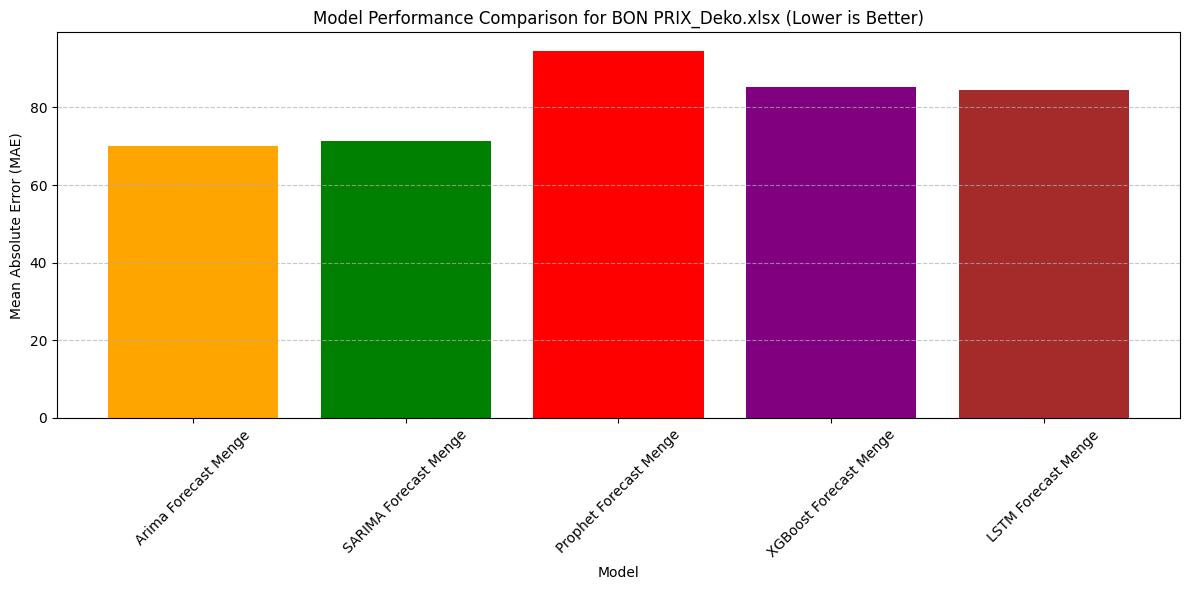

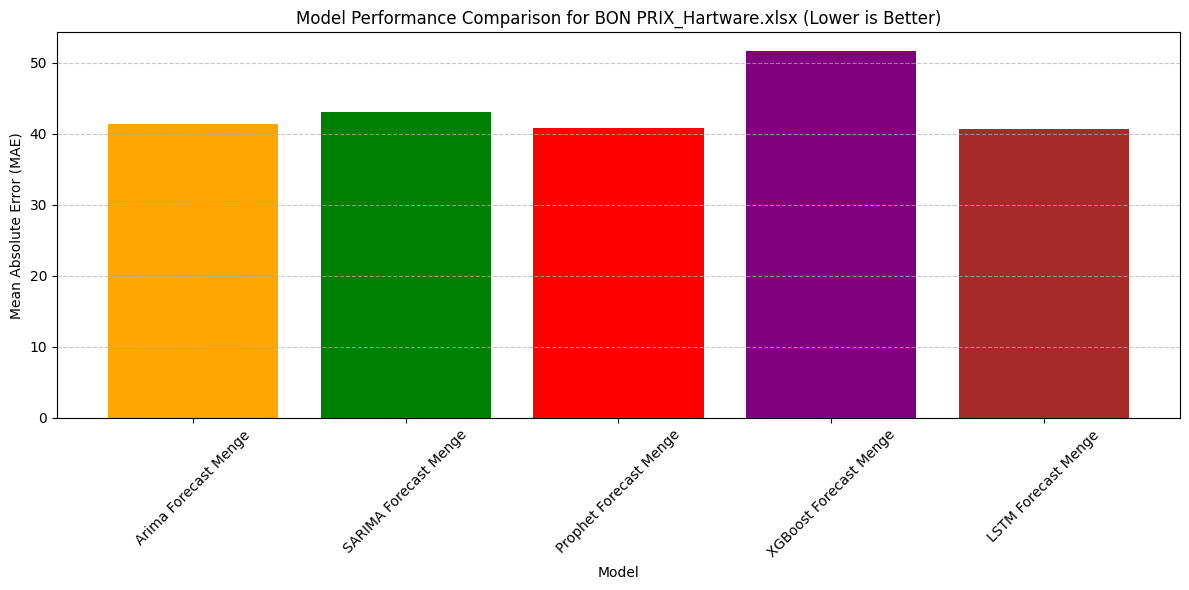

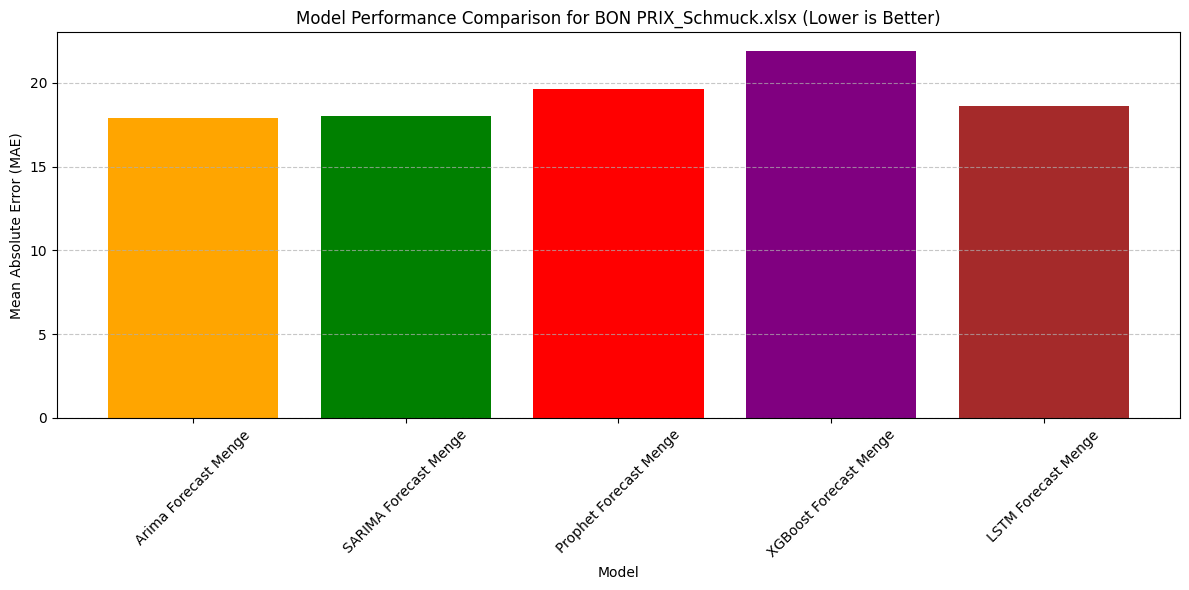

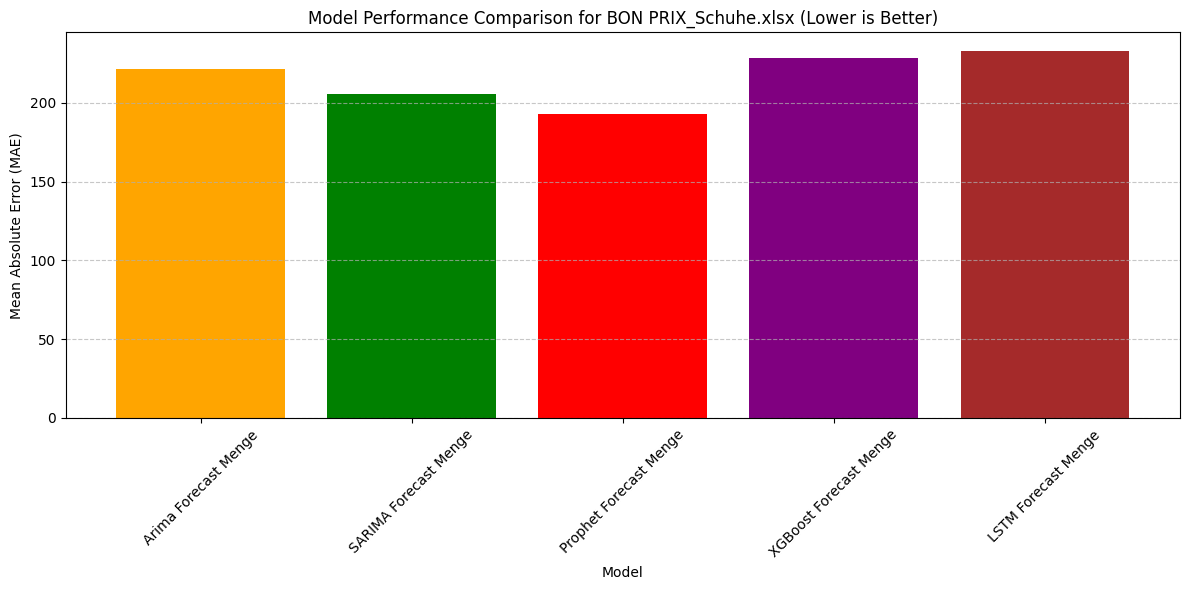

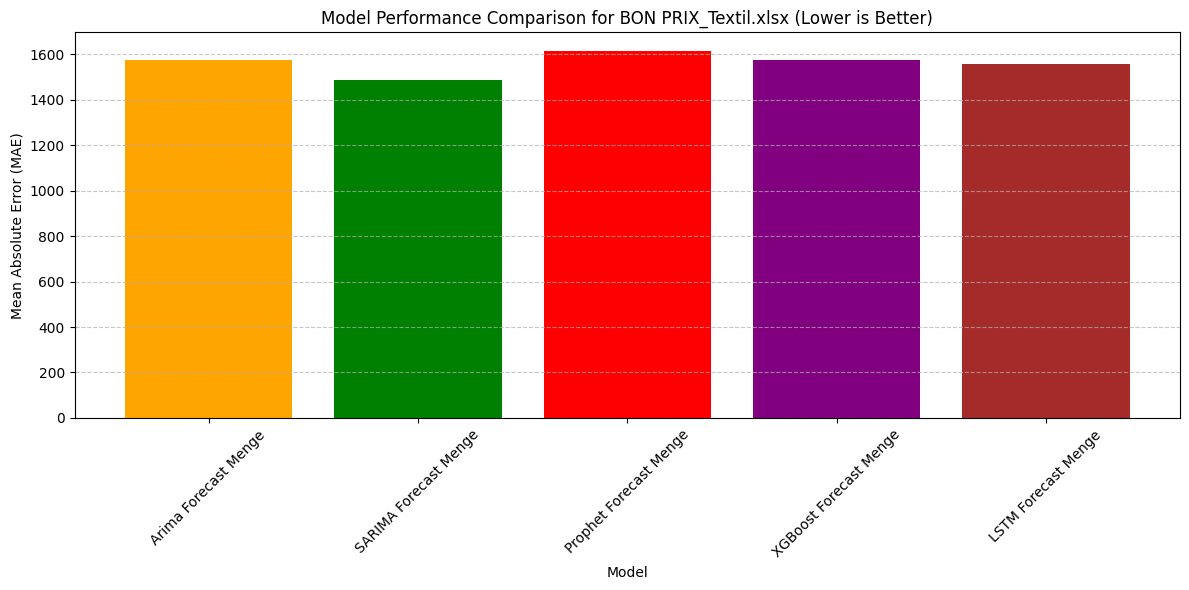

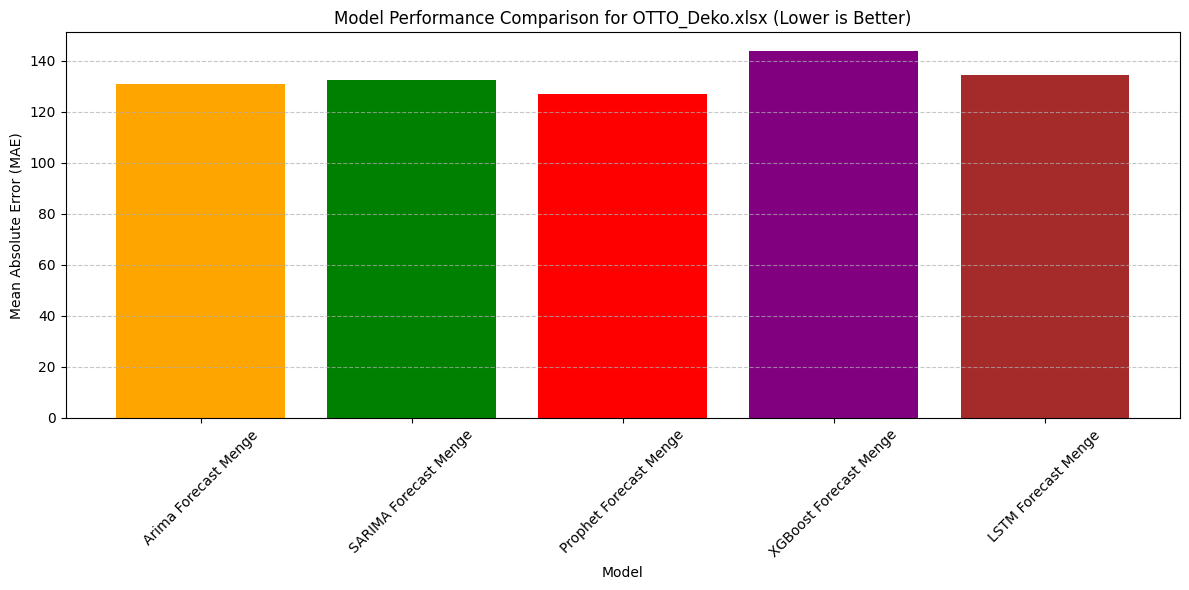

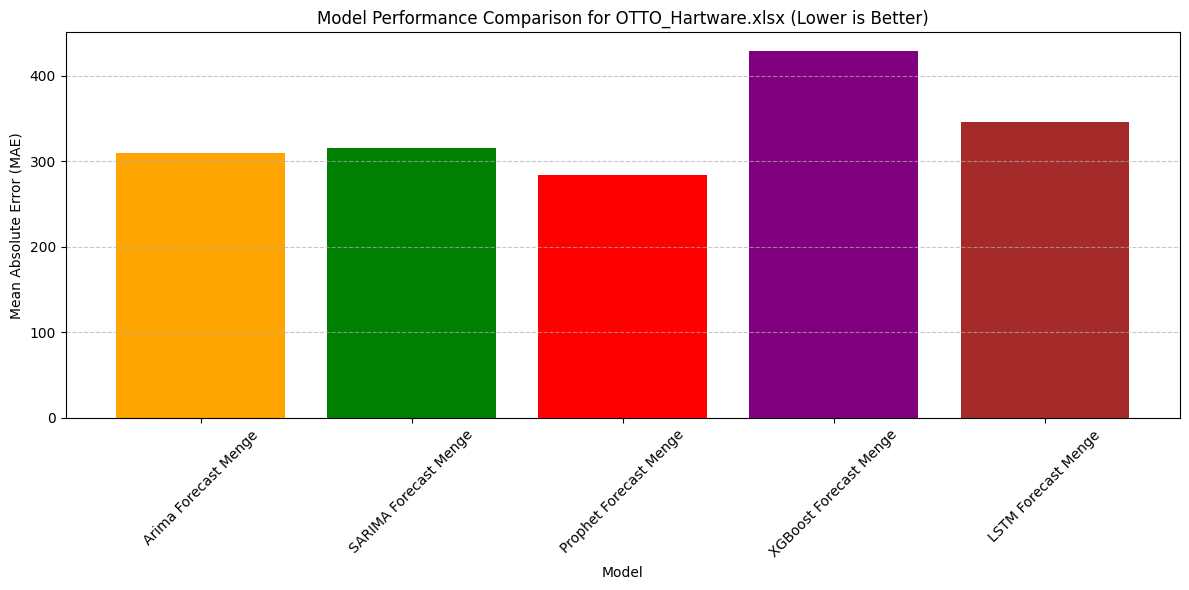

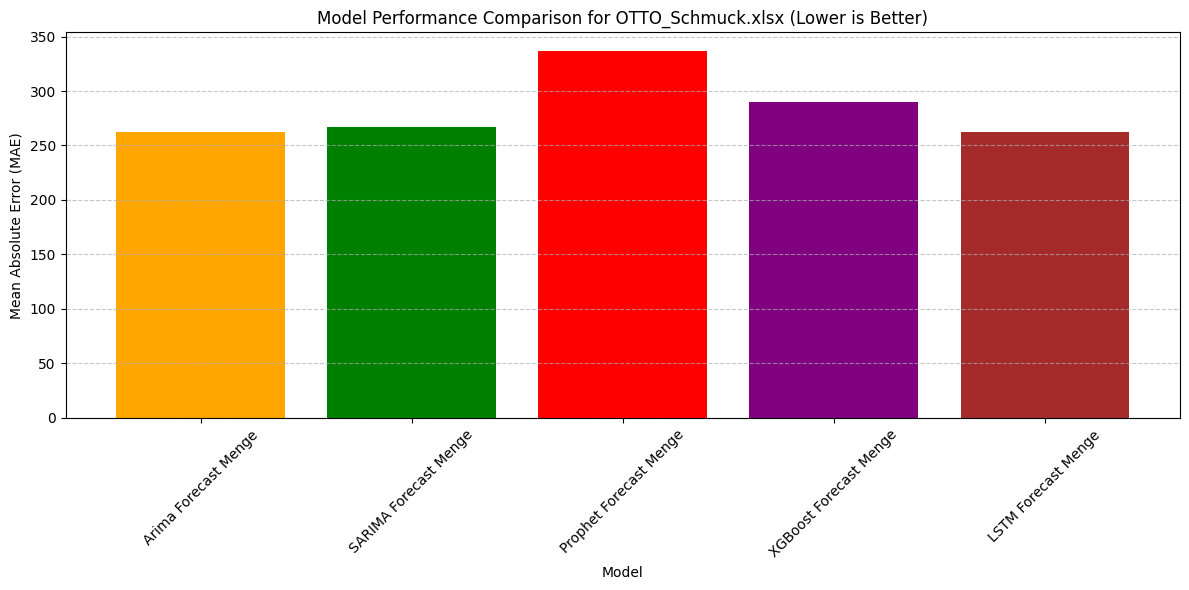

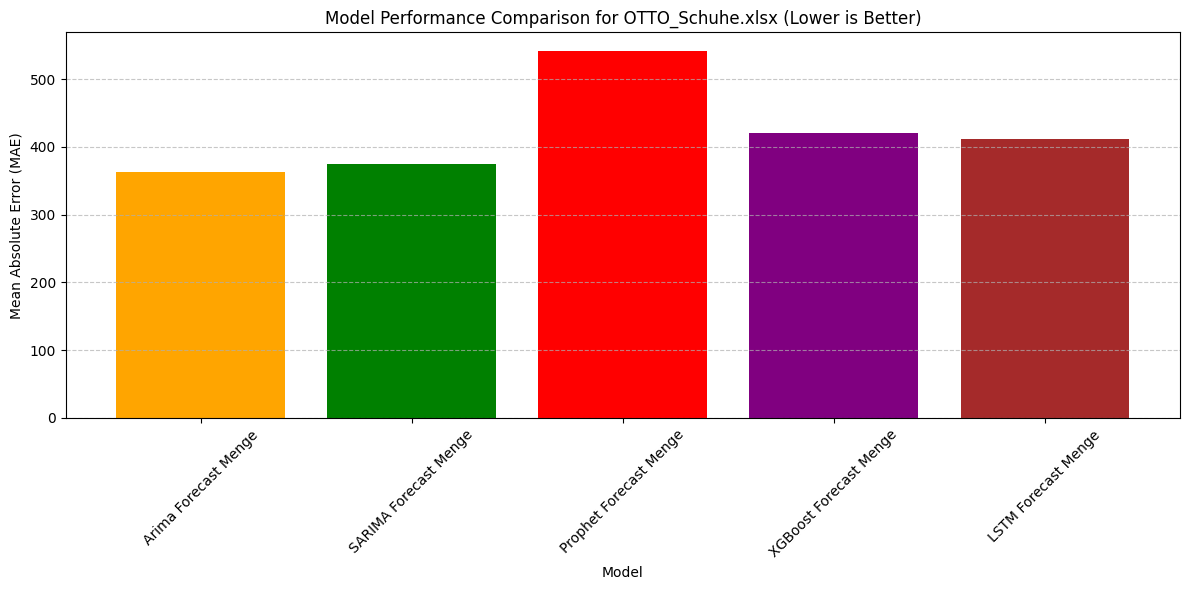

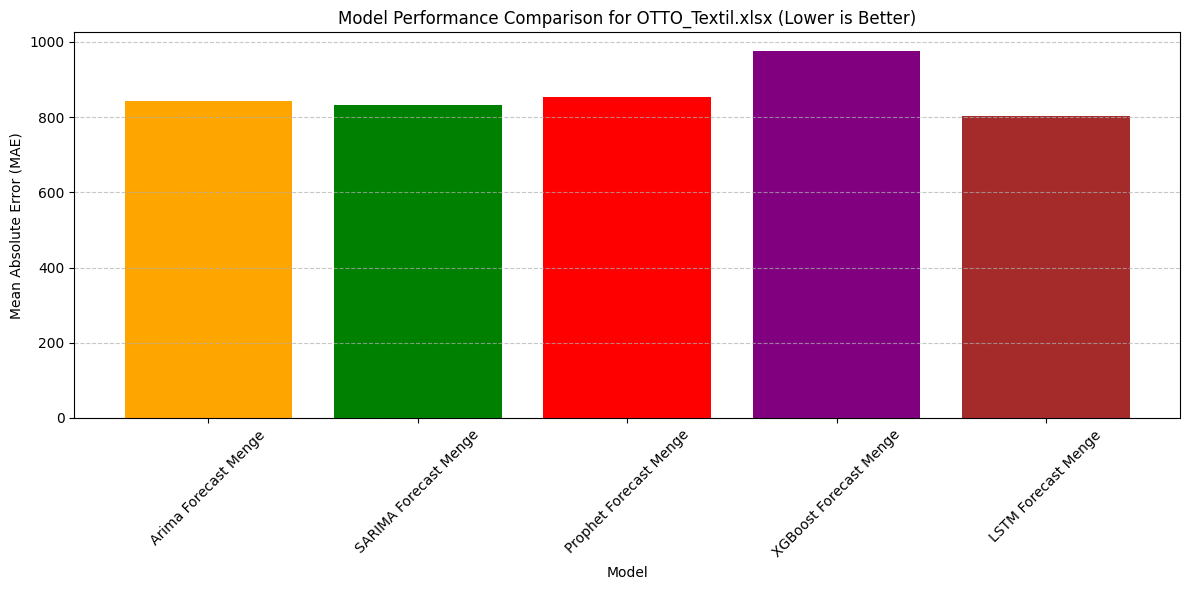

In [34]:
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt

# Function to plot errors for each dataset in its own plot
def plot_model_errors_for_each(output_dir):
    # Get all Excel files in the output directory
    forecast_files = [f for f in os.listdir(output_dir) if f.endswith('.xlsx')]

    # Models to plot
    models = [
        ("Arima Forecast Menge", "orange"),
        ("SARIMA Forecast Menge", "green"),
        ("Prophet Forecast Menge", "red"),
        ("XGBoost Forecast Menge", "purple"),
        ("LSTM Forecast Menge", "brown"),
    ]

    # Loop through each file and plot model errors
    for forecast_file in forecast_files:
        # Load the forecast results from Excel
        file_path = os.path.join(output_dir, forecast_file)
        forecast_results = pd.read_excel(file_path)
        
        # Ensure numeric columns and fill NaN values
        forecast_results["Woche Ist Menge"] = pd.to_numeric(
            forecast_results["Woche Ist Menge"], errors="coerce"
        ).fillna(0)

        # Calculate errors for each model
        errors = {}
        for model, _ in models:
            if model in forecast_results:
                forecast_results[model] = pd.to_numeric(forecast_results[model], errors="coerce").fillna(0)
                errors[model] = np.mean(
                    np.abs(forecast_results["Woche Ist Menge"] - forecast_results[model])
                )  # Mean Absolute Error (MAE)

        # Convert errors to a DataFrame for easy plotting
        error_df = pd.DataFrame(list(errors.items()), columns=["Model", "MAE"])

        # Plot the errors
        plt.figure(figsize=(12, 6))
        plt.bar(error_df["Model"], error_df["MAE"], color=[color for _, color in models])
        plt.xlabel("Model")
        plt.ylabel("Mean Absolute Error (MAE)")
        plt.title(f"Model Performance Comparison for {forecast_file} (Lower is Better)")
        plt.xticks(rotation=45)
        plt.grid(axis="y", linestyle="--", alpha=0.7)
        plt.tight_layout()
        plt.show()

# Call the function to plot model errors for each dataset
plot_model_errors_for_each(output_dir)



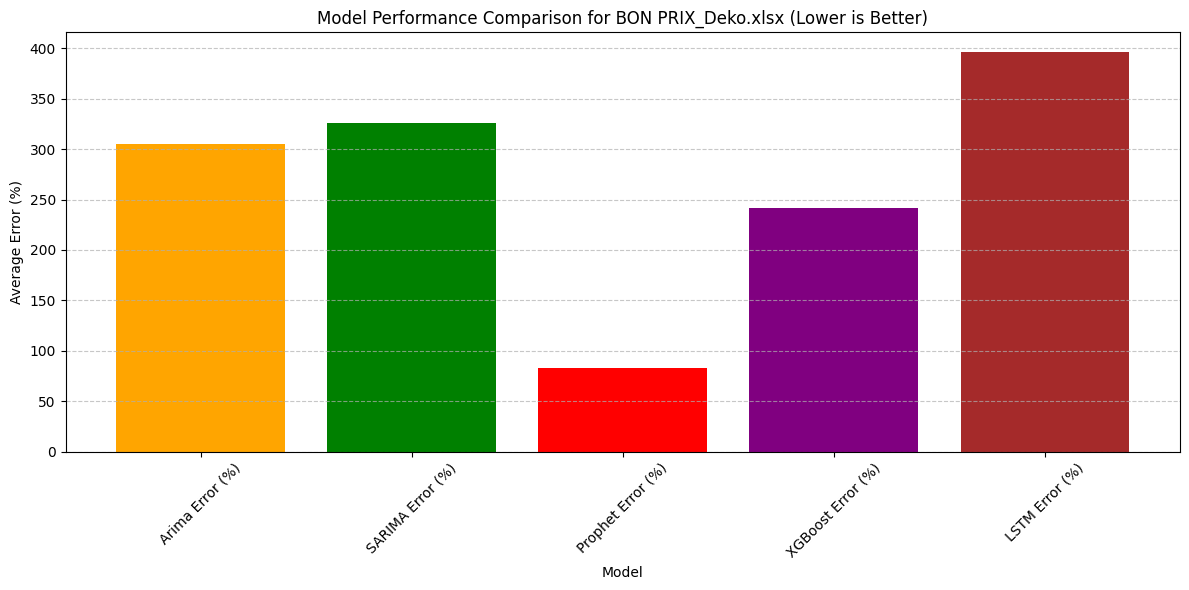

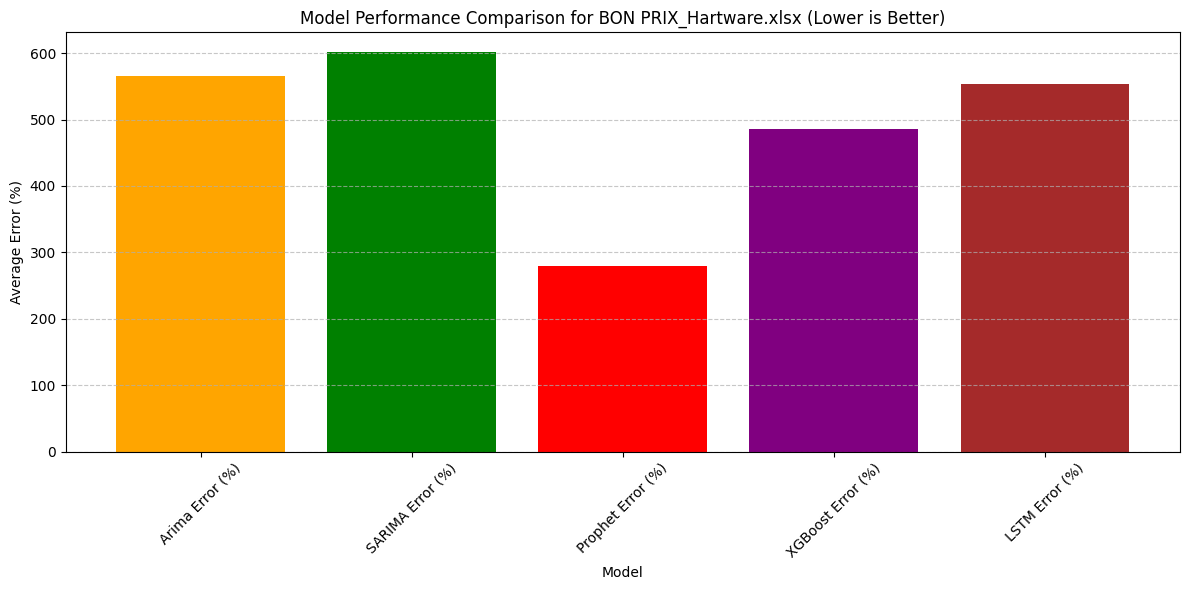

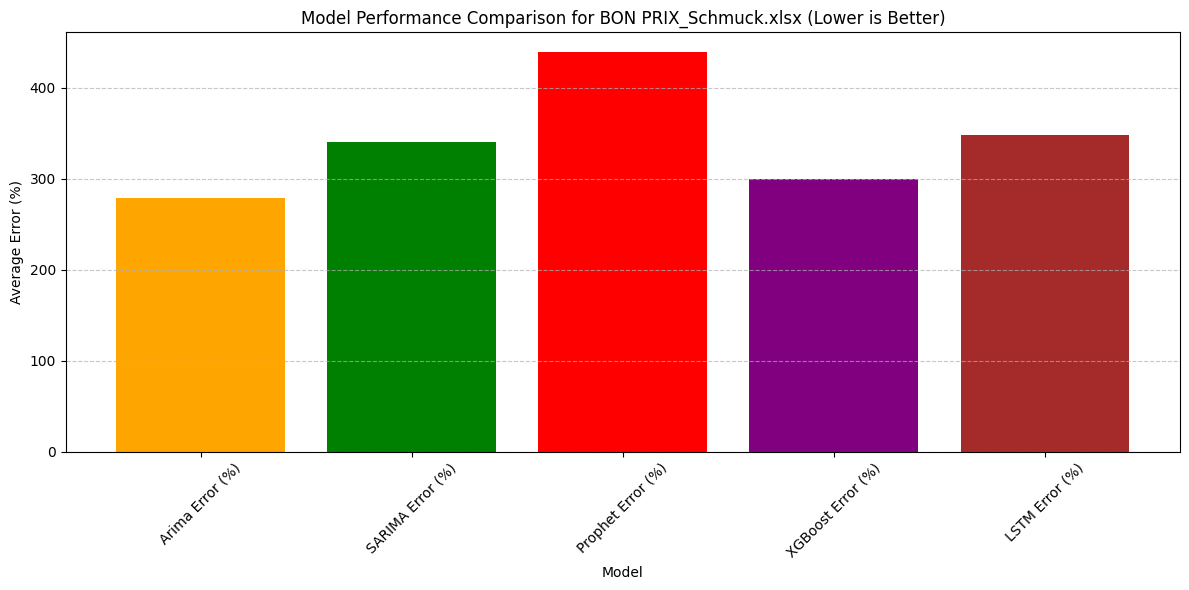

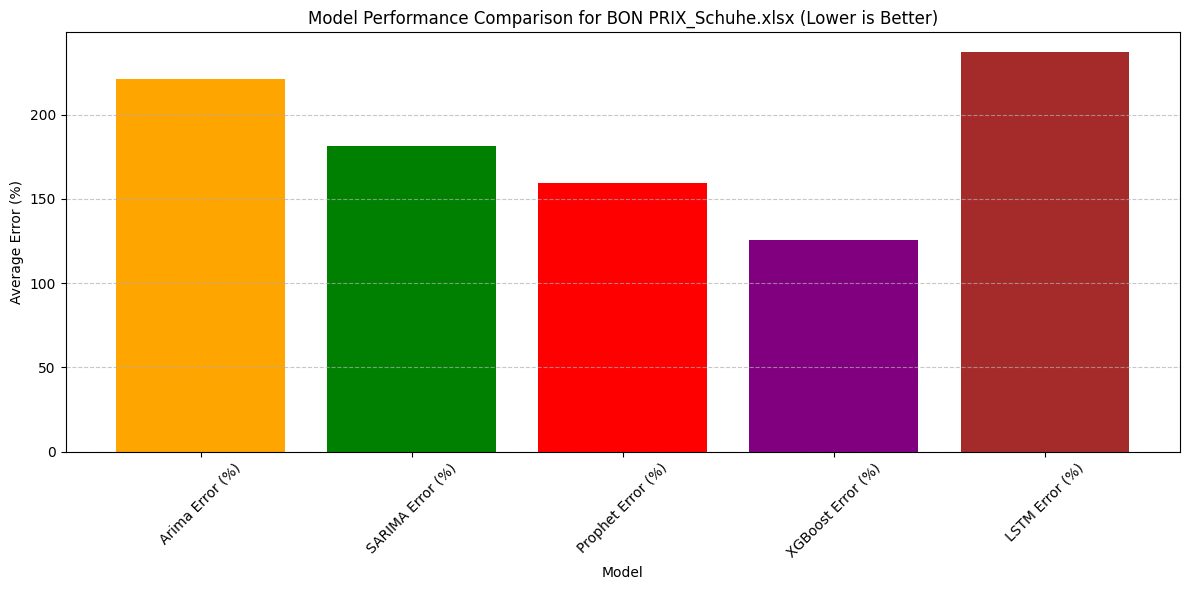

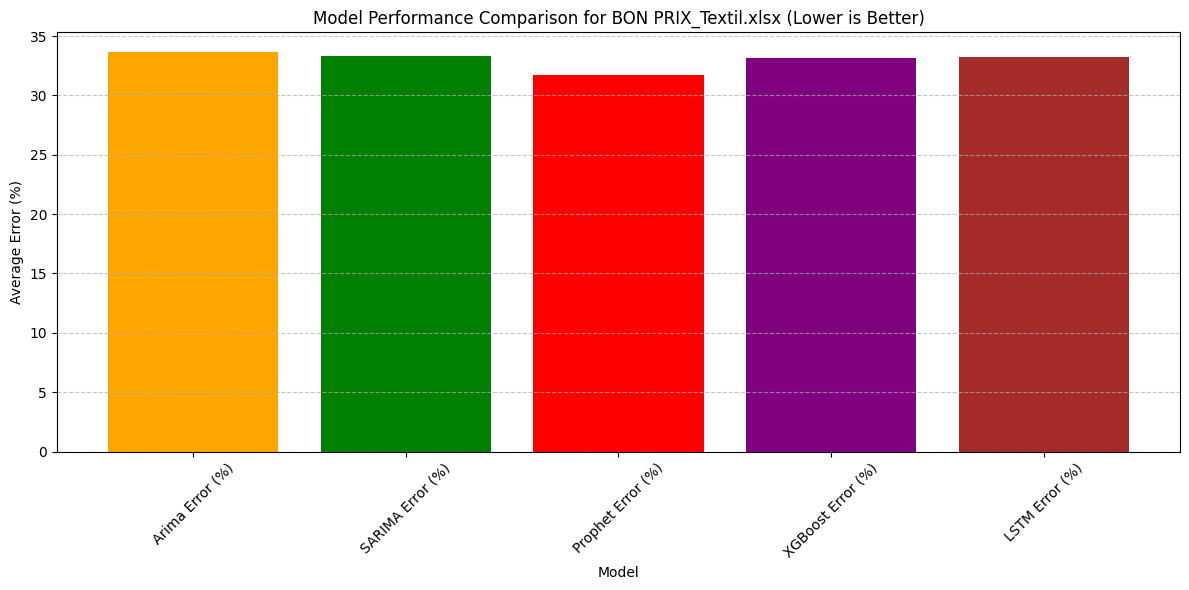

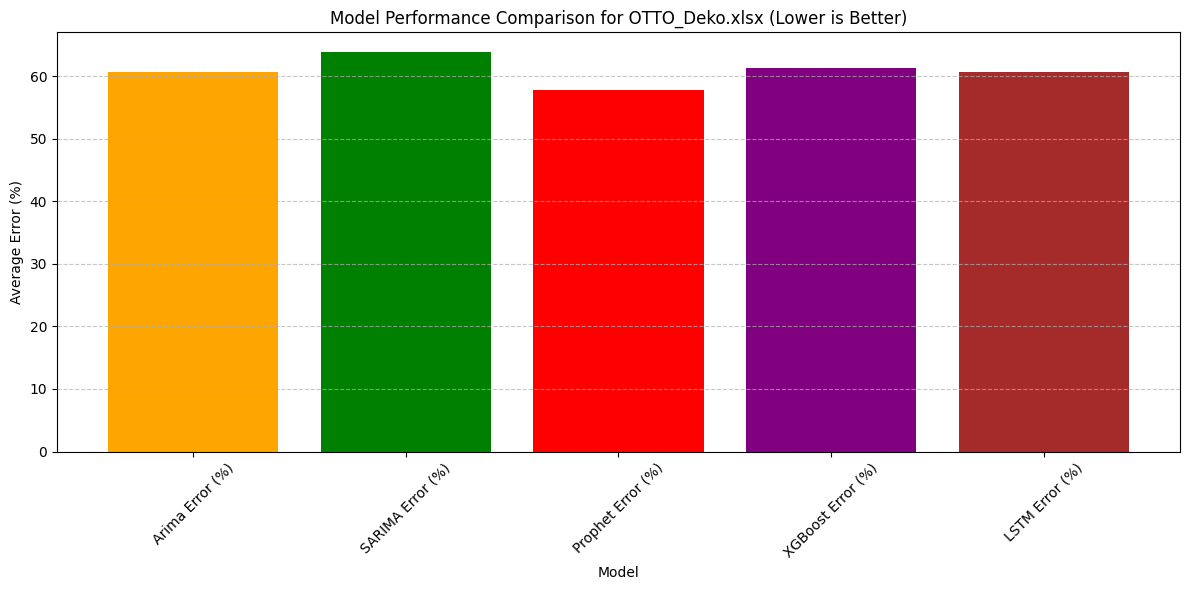

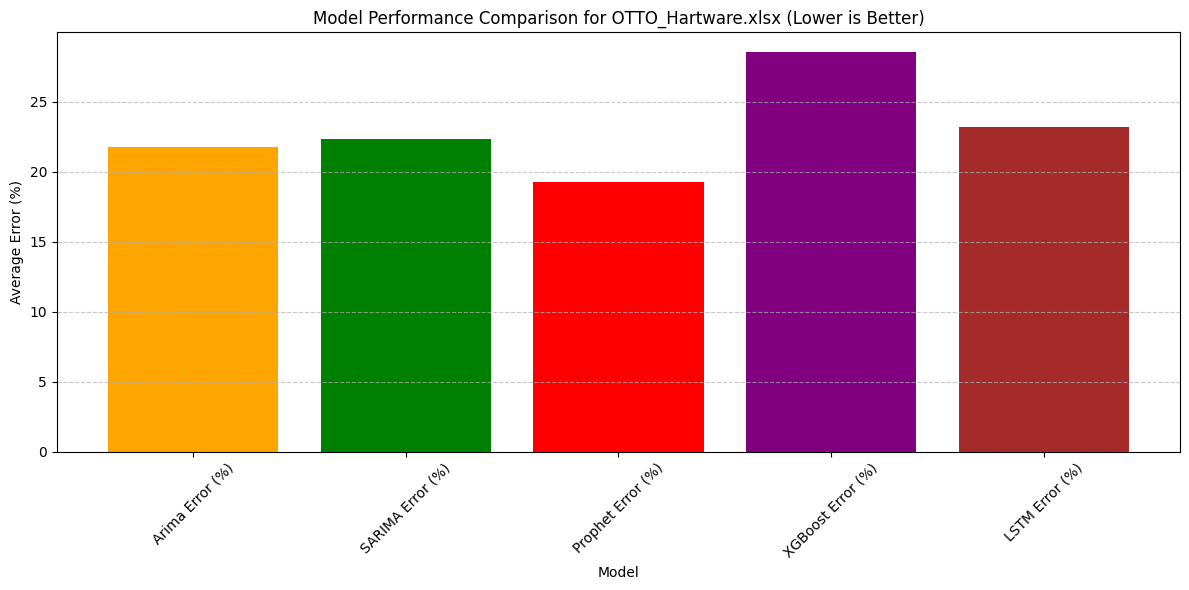

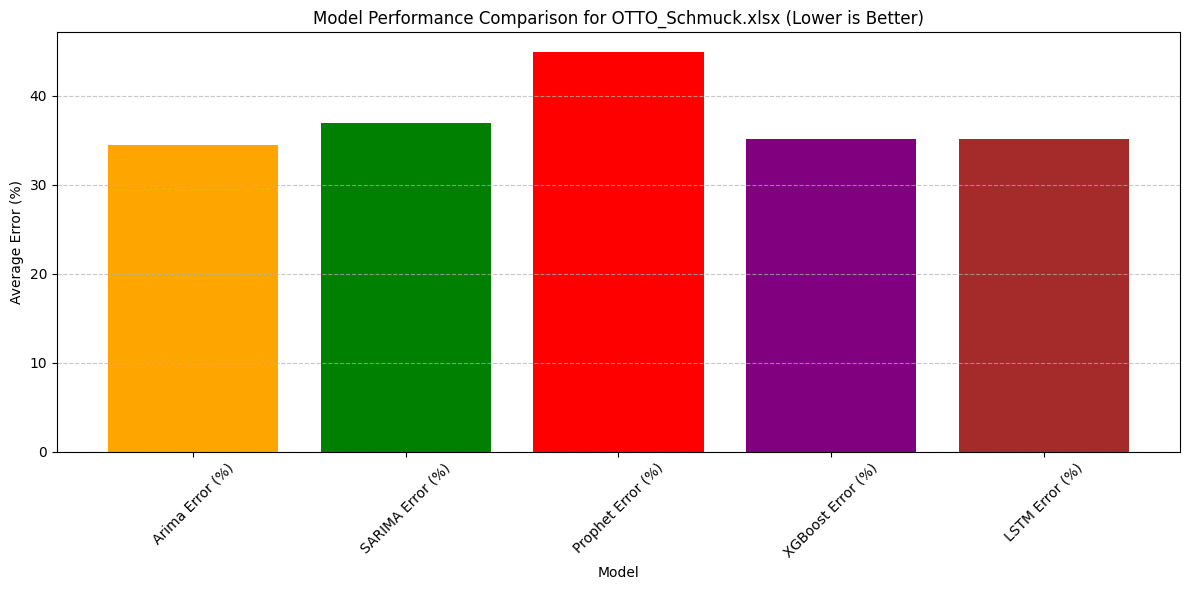

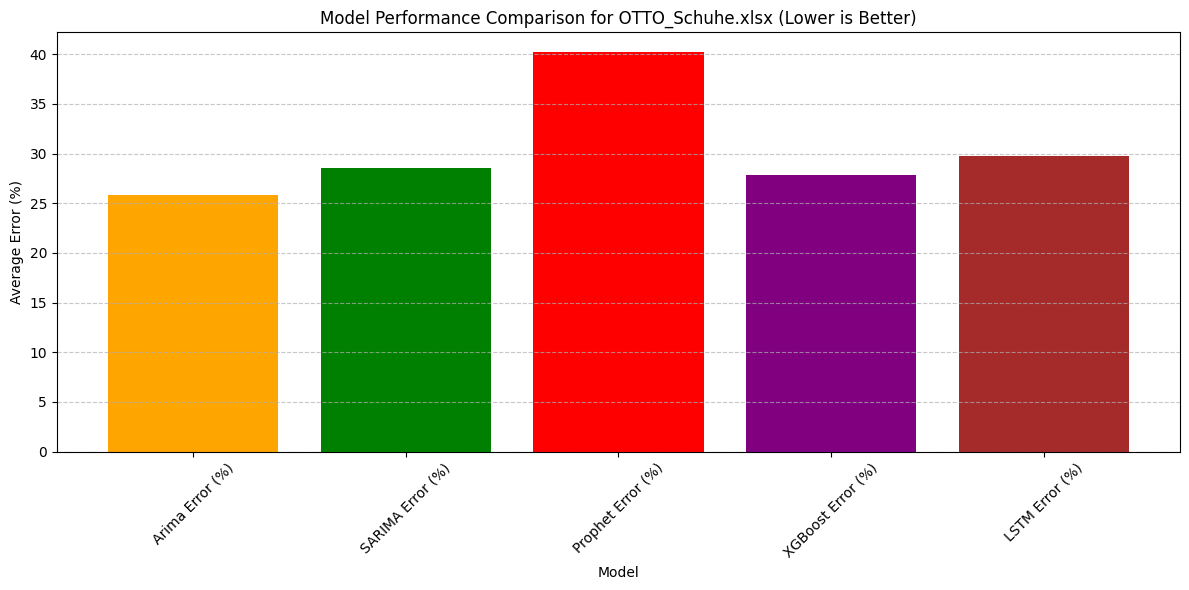

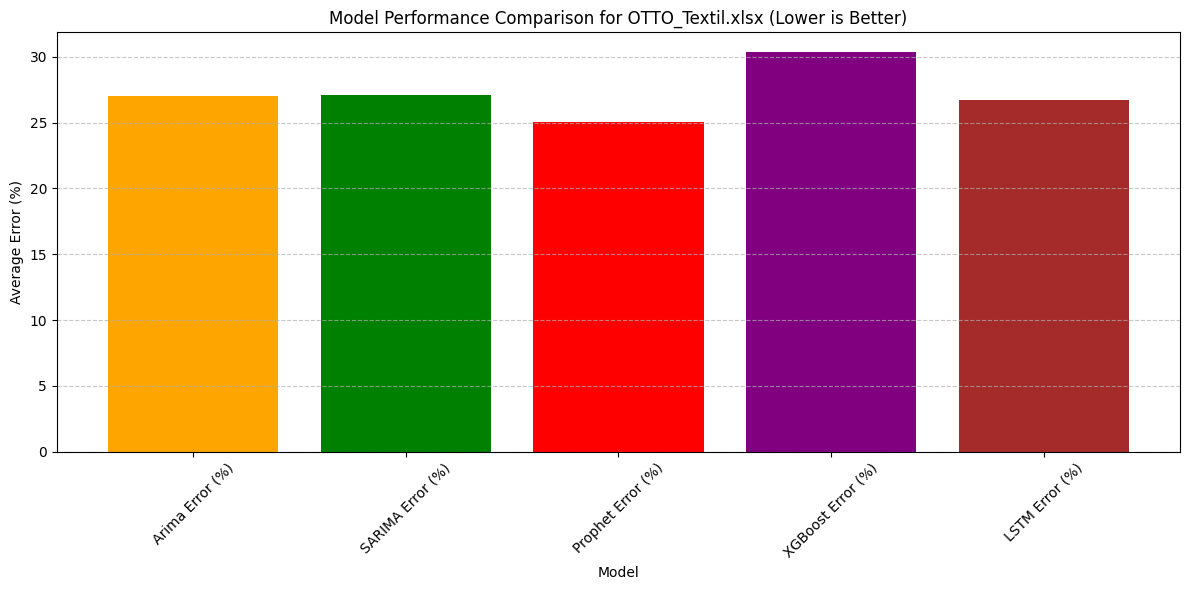

In [35]:
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt

# Function to plot percentage errors for each dataset in its own plot
def plot_model_errors_percentage_for_each(output_dir):
    # Get all Excel files in the output directory
    forecast_files = [f for f in os.listdir(output_dir) if f.endswith('.xlsx')]

    # Models to plot
    models = [
        ("Arima Error (%)", "orange"),
        ("SARIMA Error (%)", "green"),
        ("Prophet Error (%)", "red"),
        ("XGBoost Error (%)", "purple"),
        ("LSTM Error (%)", "brown"),
    ]

    # Loop through each file and plot model percentage errors
    for forecast_file in forecast_files:
        # Load the forecast results from Excel
        file_path = os.path.join(output_dir, forecast_file)
        forecast_results = pd.read_excel(file_path)
        
        # Initialize a dictionary to store errors
        errors_percentage = {
            "Arima Error (%)": [],
            "SARIMA Error (%)": [],
            "Prophet Error (%)": [],
            "XGBoost Error (%)": [],
            "LSTM Error (%)": []
        }

        # Iterate over each row in the forecast data
        for _, row in forecast_results.iterrows():
            actual_value = row["Woche Ist Menge"]
            arima_error = (
                round(abs((actual_value - row["Arima Forecast Menge"]) / actual_value) * 100) 
                if actual_value and not pd.isna(actual_value) else None
            )
            sarima_error = (
                round(abs((actual_value - row["SARIMA Forecast Menge"]) / actual_value) * 100) 
                if actual_value and not pd.isna(actual_value) else None
            )
            prophet_error = (
                round(abs((actual_value - row["Prophet Forecast Menge"]) / actual_value) * 100) 
                if actual_value and not pd.isna(actual_value) else None
            )
            xgboost_error = (
                round(abs((actual_value - row["XGBoost Forecast Menge"]) / actual_value) * 100) 
                if actual_value and not pd.isna(actual_value) else None
            )
            lstm_error = (
                round(abs((actual_value - row["LSTM Forecast Menge"]) / actual_value) * 100) 
                if actual_value and not pd.isna(actual_value) else None
            )

            # Append the errors to the corresponding lists
            if arima_error is not None:
                errors_percentage["Arima Error (%)"].append(arima_error)
            if sarima_error is not None:
                errors_percentage["SARIMA Error (%)"].append(sarima_error)
            if prophet_error is not None:
                errors_percentage["Prophet Error (%)"].append(prophet_error)
            if xgboost_error is not None:
                errors_percentage["XGBoost Error (%)"].append(xgboost_error)
            if lstm_error is not None:
                errors_percentage["LSTM Error (%)"].append(lstm_error)

        # Calculate the average error for each model
        avg_errors_percentage = {model: np.mean(errors) for model, errors in errors_percentage.items()}

        # Convert errors to a DataFrame for easy plotting
        error_df = pd.DataFrame(list(avg_errors_percentage.items()), columns=["Model", "Average Error (%)"])

        # Plot the errors
        plt.figure(figsize=(12, 6))
        plt.bar(error_df["Model"], error_df["Average Error (%)"], color=['orange', 'green', 'red', 'purple', 'brown'])
        plt.xlabel("Model")
        plt.ylabel("Average Error (%)")
        plt.title(f"Model Performance Comparison for {forecast_file} (Lower is Better)")
        plt.xticks(rotation=45)
        plt.grid(axis="y", linestyle="--", alpha=0.7)
        plt.tight_layout()
        plt.show()

# Call the function to plot model errors percentage for each dataset
plot_model_errors_percentage_for_each(output_dir)


Forecasts DataFrame Info for BON PRIX_Deko.xlsx:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55 entries, 0 to 54
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   Weekly dates                54 non-null     datetime64[ns]
 1   Woche Ist Menge             55 non-null     float64       
 2   Arima Forecast Menge        54 non-null     float64       
 3   Arima Forecast Error (%)    55 non-null     int64         
 4   SARIMA Forecast Menge       54 non-null     float64       
 5   SARIMA Forecast Error (%)   55 non-null     int64         
 6   Prophet Forecast Menge      54 non-null     float64       
 7   Prophet Forecast Error (%)  55 non-null     int64         
 8   XGBoost Forecast Menge      54 non-null     float64       
 9   XGBoost Forecast Error (%)  55 non-null     int64         
 10  LSTM Forecast Menge         54 non-null     float64       
 11  LSTM Foreca

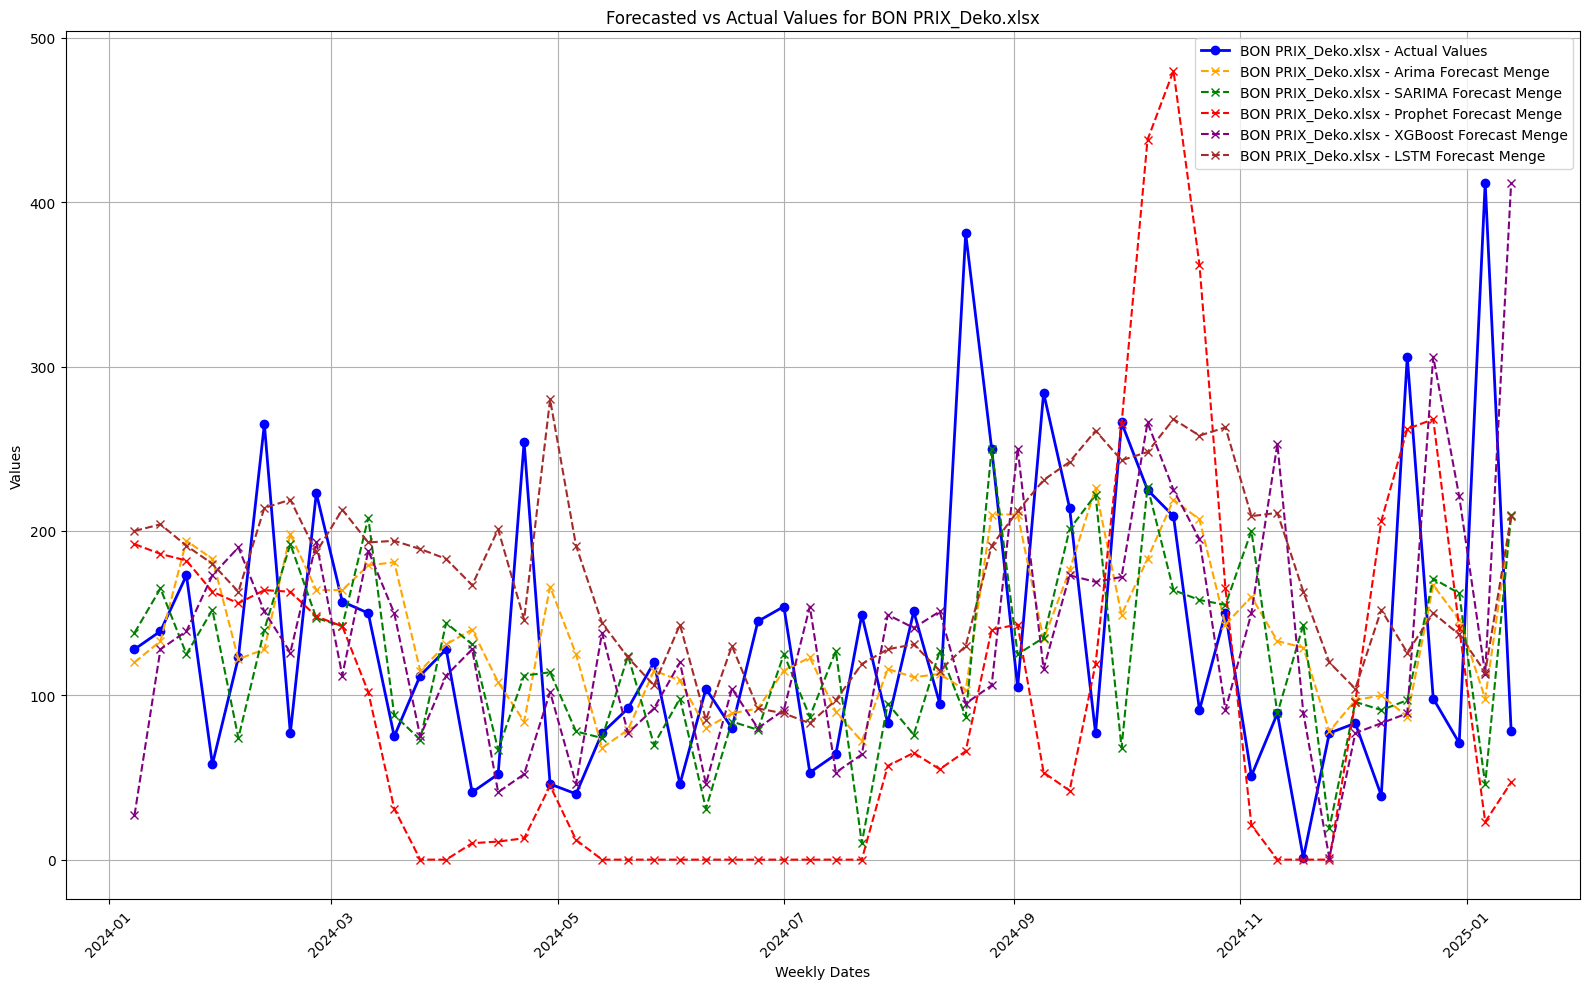

Forecasts DataFrame Info for BON PRIX_Hartware.xlsx:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55 entries, 0 to 54
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   Weekly dates                54 non-null     datetime64[ns]
 1   Woche Ist Menge             55 non-null     float64       
 2   Arima Forecast Menge        54 non-null     float64       
 3   Arima Forecast Error (%)    55 non-null     int64         
 4   SARIMA Forecast Menge       54 non-null     float64       
 5   SARIMA Forecast Error (%)   55 non-null     int64         
 6   Prophet Forecast Menge      54 non-null     float64       
 7   Prophet Forecast Error (%)  55 non-null     int64         
 8   XGBoost Forecast Menge      54 non-null     float64       
 9   XGBoost Forecast Error (%)  55 non-null     int64         
 10  LSTM Forecast Menge         54 non-null     float64       
 11  LSTM Fo

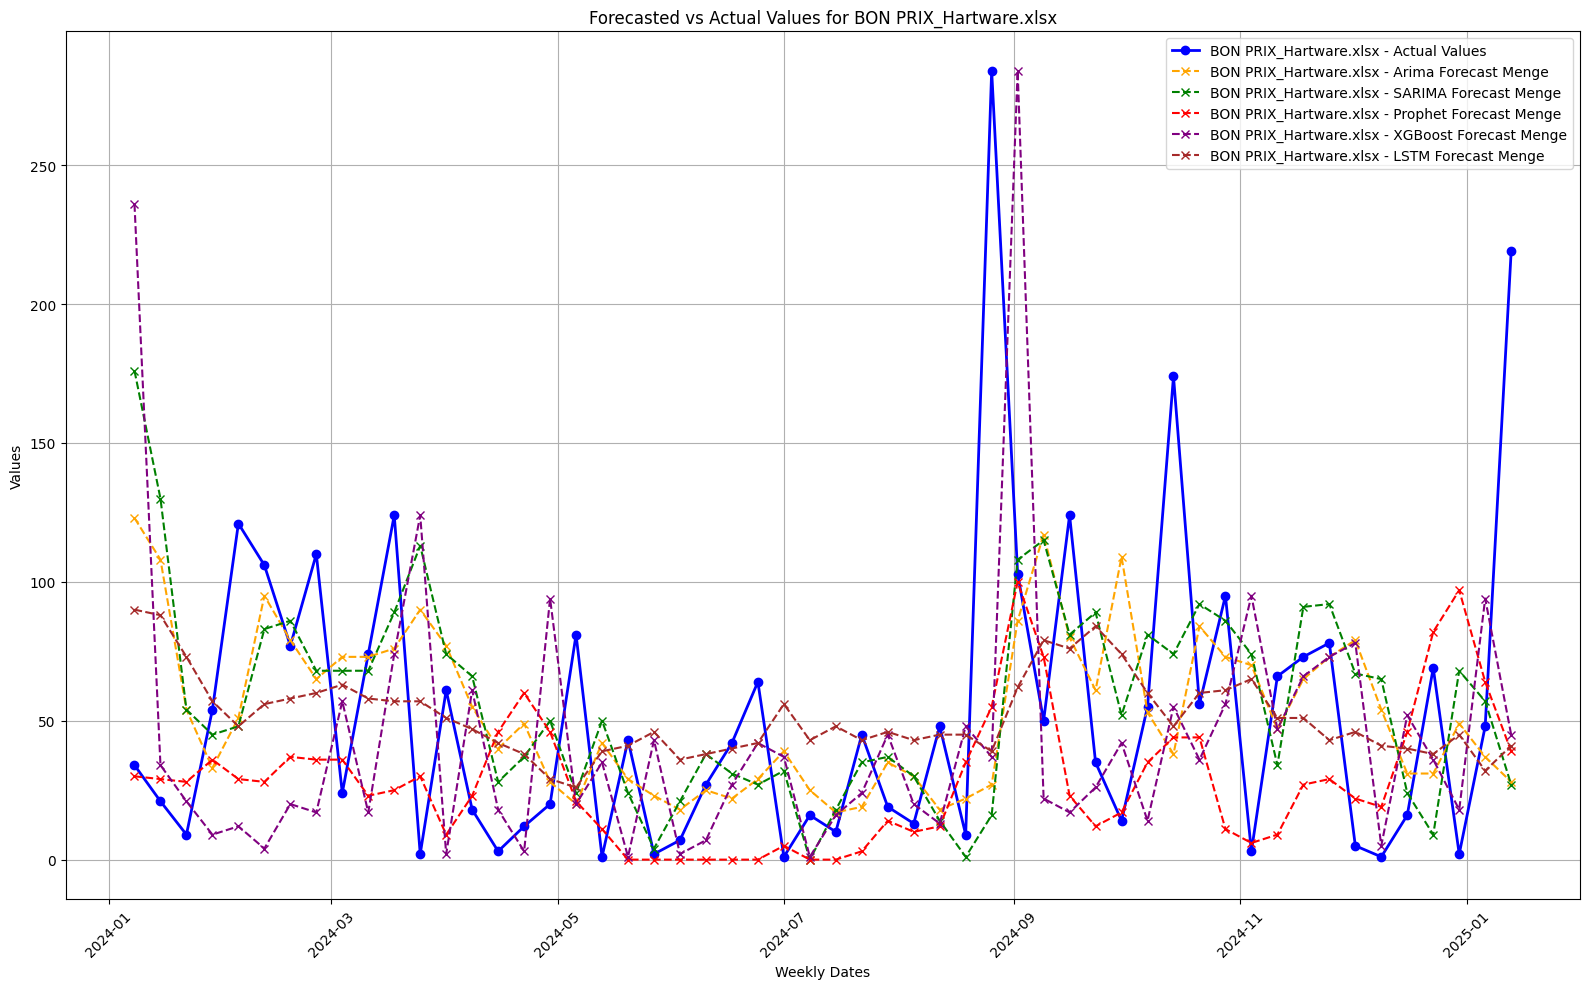

Forecasts DataFrame Info for BON PRIX_Schmuck.xlsx:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55 entries, 0 to 54
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   Weekly dates                54 non-null     datetime64[ns]
 1   Woche Ist Menge             55 non-null     float64       
 2   Arima Forecast Menge        54 non-null     float64       
 3   Arima Forecast Error (%)    39 non-null     float64       
 4   SARIMA Forecast Menge       54 non-null     float64       
 5   SARIMA Forecast Error (%)   39 non-null     float64       
 6   Prophet Forecast Menge      54 non-null     float64       
 7   Prophet Forecast Error (%)  39 non-null     float64       
 8   XGBoost Forecast Menge      54 non-null     float64       
 9   XGBoost Forecast Error (%)  39 non-null     float64       
 10  LSTM Forecast Menge         54 non-null     float64       
 11  LSTM For

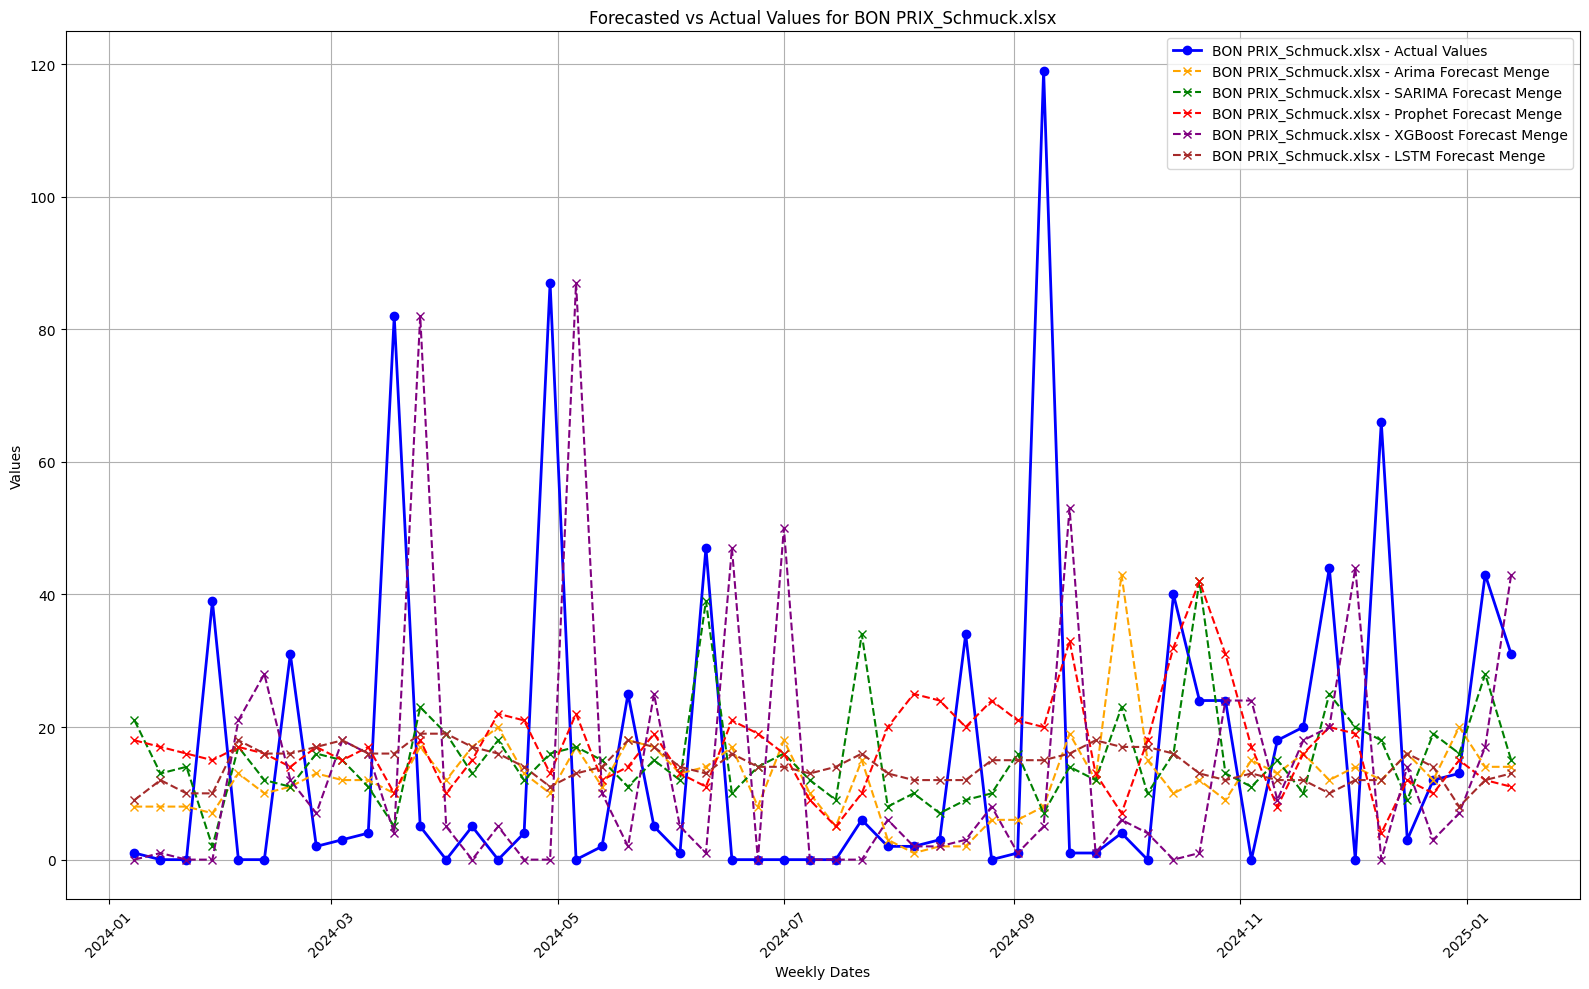

Forecasts DataFrame Info for BON PRIX_Schuhe.xlsx:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55 entries, 0 to 54
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   Weekly dates                54 non-null     datetime64[ns]
 1   Woche Ist Menge             55 non-null     float64       
 2   Arima Forecast Menge        54 non-null     float64       
 3   Arima Forecast Error (%)    55 non-null     int64         
 4   SARIMA Forecast Menge       54 non-null     float64       
 5   SARIMA Forecast Error (%)   55 non-null     int64         
 6   Prophet Forecast Menge      54 non-null     float64       
 7   Prophet Forecast Error (%)  55 non-null     int64         
 8   XGBoost Forecast Menge      54 non-null     float64       
 9   XGBoost Forecast Error (%)  55 non-null     int64         
 10  LSTM Forecast Menge         54 non-null     float64       
 11  LSTM Fore

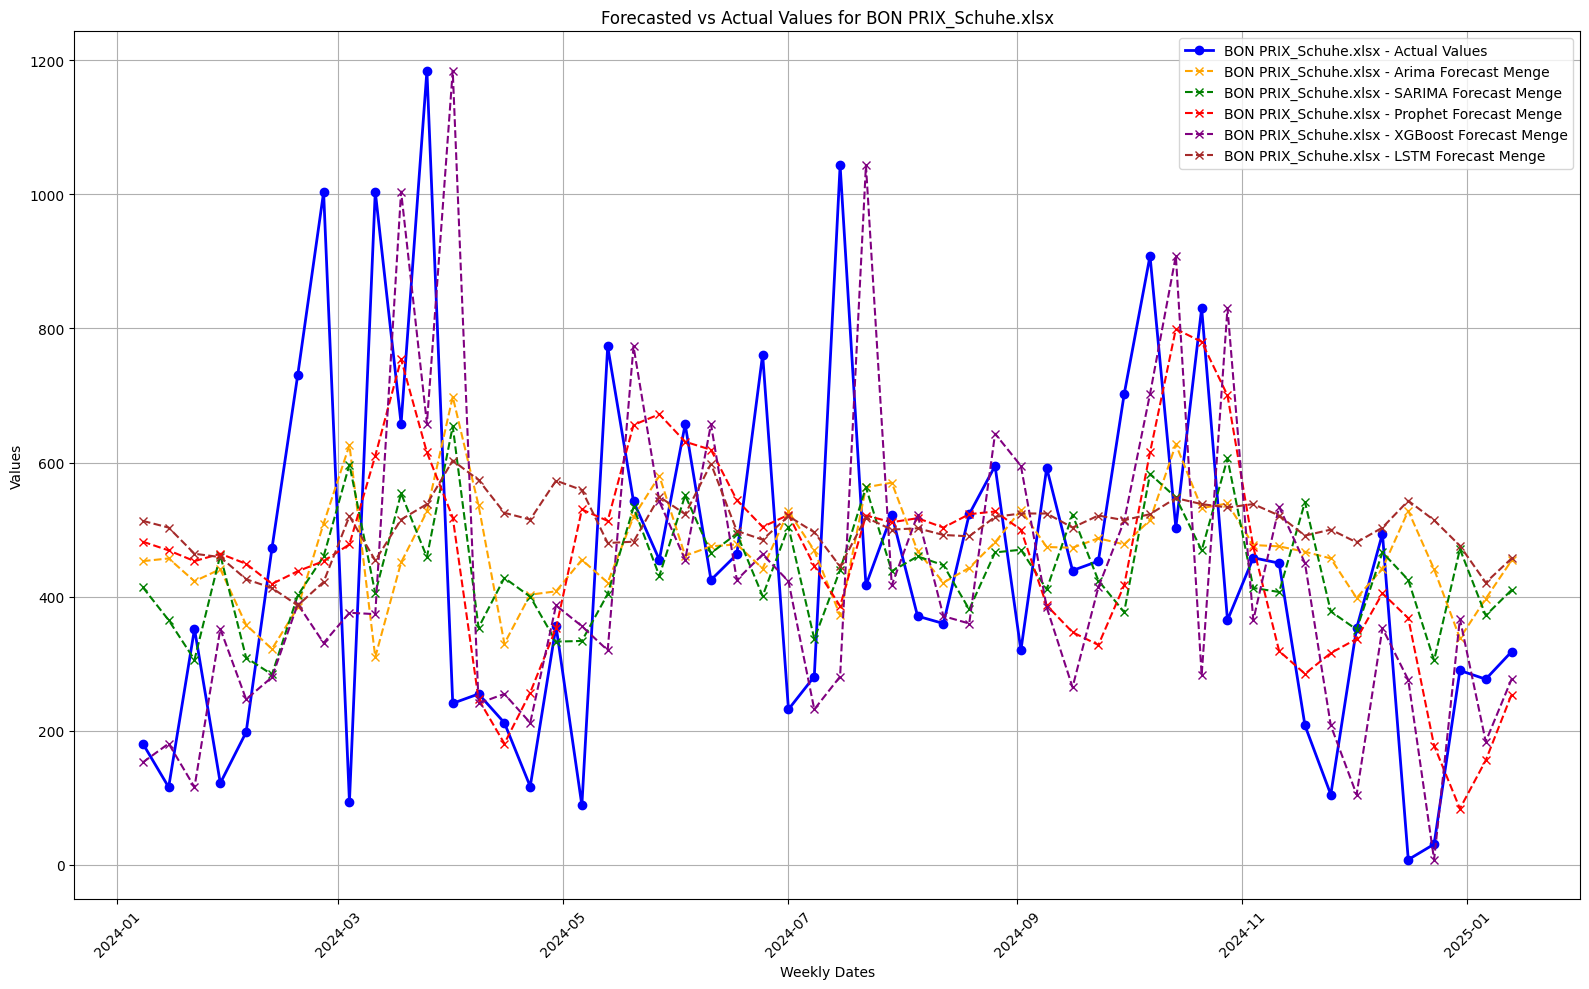

Forecasts DataFrame Info for BON PRIX_Textil.xlsx:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55 entries, 0 to 54
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   Weekly dates                54 non-null     datetime64[ns]
 1   Woche Ist Menge             55 non-null     float64       
 2   Arima Forecast Menge        54 non-null     float64       
 3   Arima Forecast Error (%)    55 non-null     int64         
 4   SARIMA Forecast Menge       54 non-null     float64       
 5   SARIMA Forecast Error (%)   55 non-null     int64         
 6   Prophet Forecast Menge      54 non-null     float64       
 7   Prophet Forecast Error (%)  55 non-null     int64         
 8   XGBoost Forecast Menge      54 non-null     float64       
 9   XGBoost Forecast Error (%)  55 non-null     int64         
 10  LSTM Forecast Menge         54 non-null     float64       
 11  LSTM Fore

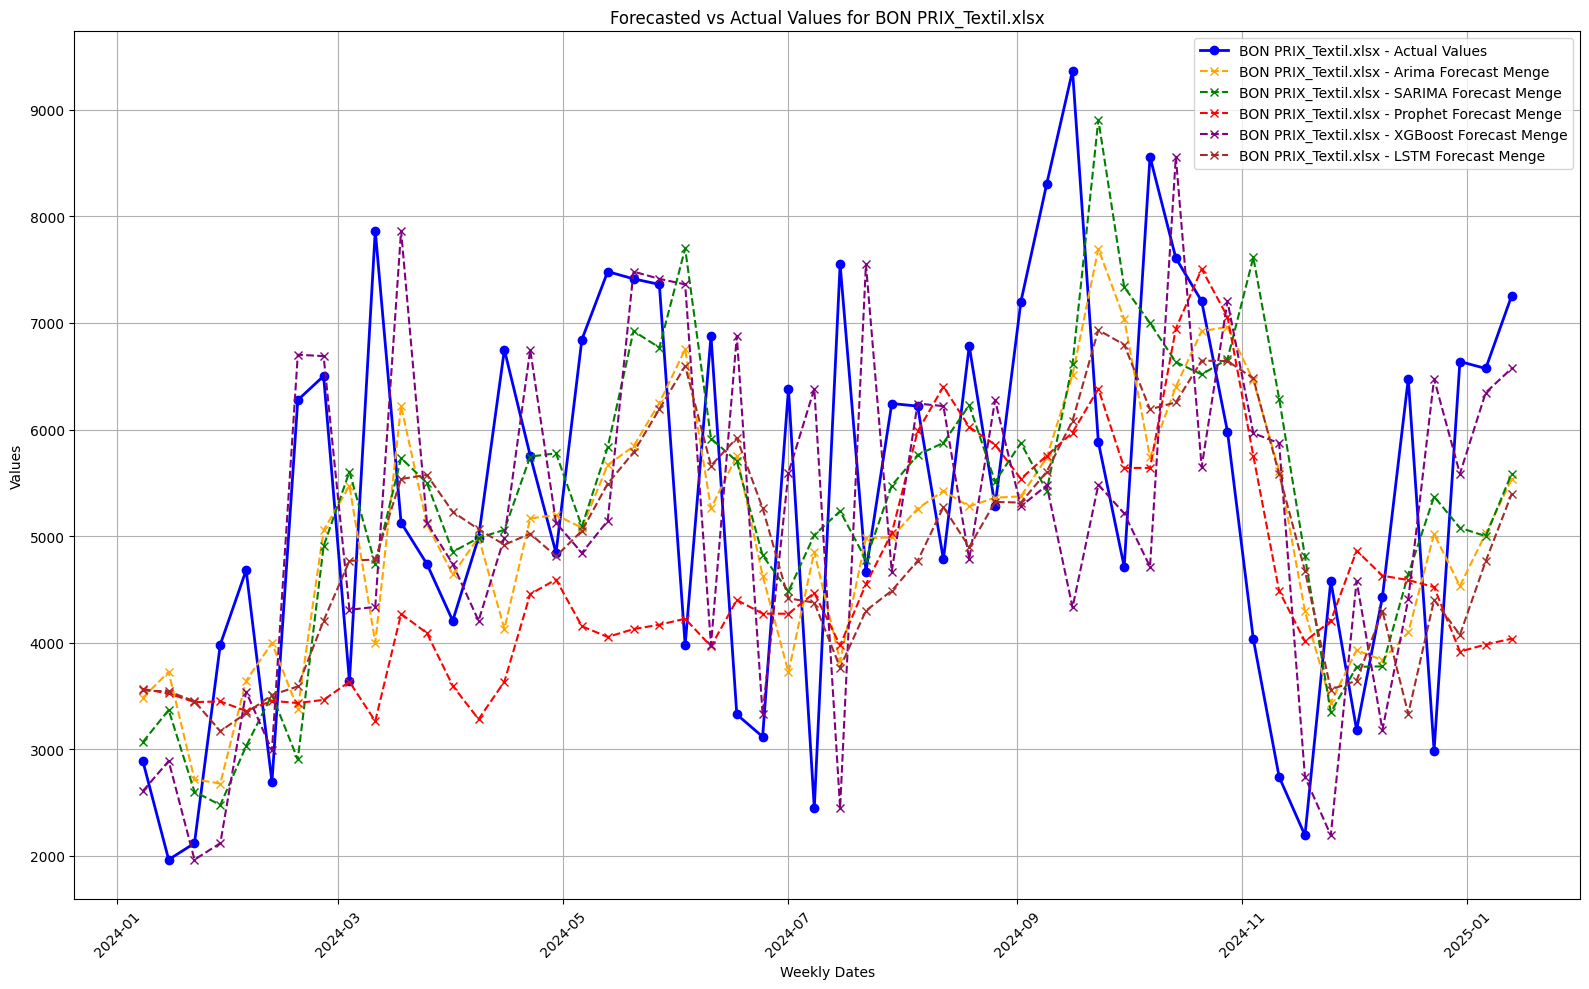

Forecasts DataFrame Info for OTTO_Deko.xlsx:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55 entries, 0 to 54
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   Weekly dates                54 non-null     datetime64[ns]
 1   Woche Ist Menge             55 non-null     float64       
 2   Arima Forecast Menge        54 non-null     float64       
 3   Arima Forecast Error (%)    55 non-null     int64         
 4   SARIMA Forecast Menge       54 non-null     float64       
 5   SARIMA Forecast Error (%)   55 non-null     int64         
 6   Prophet Forecast Menge      54 non-null     float64       
 7   Prophet Forecast Error (%)  55 non-null     int64         
 8   XGBoost Forecast Menge      54 non-null     float64       
 9   XGBoost Forecast Error (%)  55 non-null     int64         
 10  LSTM Forecast Menge         54 non-null     float64       
 11  LSTM Forecast E

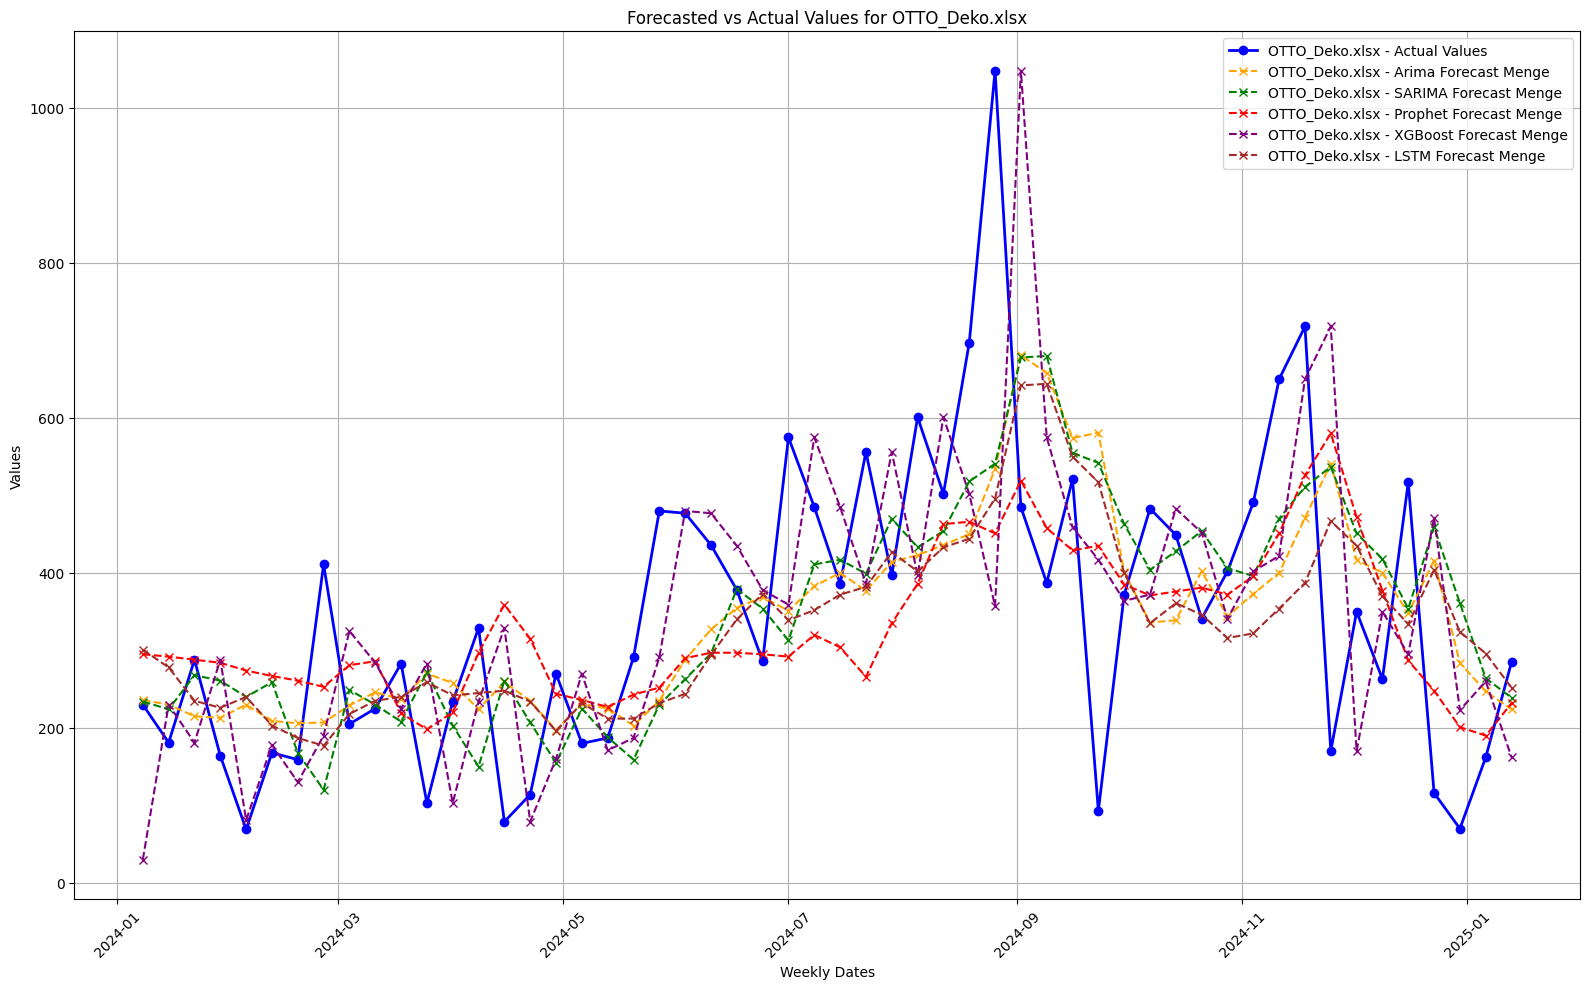

Forecasts DataFrame Info for OTTO_Hartware.xlsx:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55 entries, 0 to 54
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   Weekly dates                54 non-null     datetime64[ns]
 1   Woche Ist Menge             55 non-null     float64       
 2   Arima Forecast Menge        54 non-null     float64       
 3   Arima Forecast Error (%)    55 non-null     int64         
 4   SARIMA Forecast Menge       54 non-null     float64       
 5   SARIMA Forecast Error (%)   55 non-null     int64         
 6   Prophet Forecast Menge      54 non-null     float64       
 7   Prophet Forecast Error (%)  55 non-null     int64         
 8   XGBoost Forecast Menge      54 non-null     float64       
 9   XGBoost Forecast Error (%)  55 non-null     int64         
 10  LSTM Forecast Menge         54 non-null     float64       
 11  LSTM Foreca

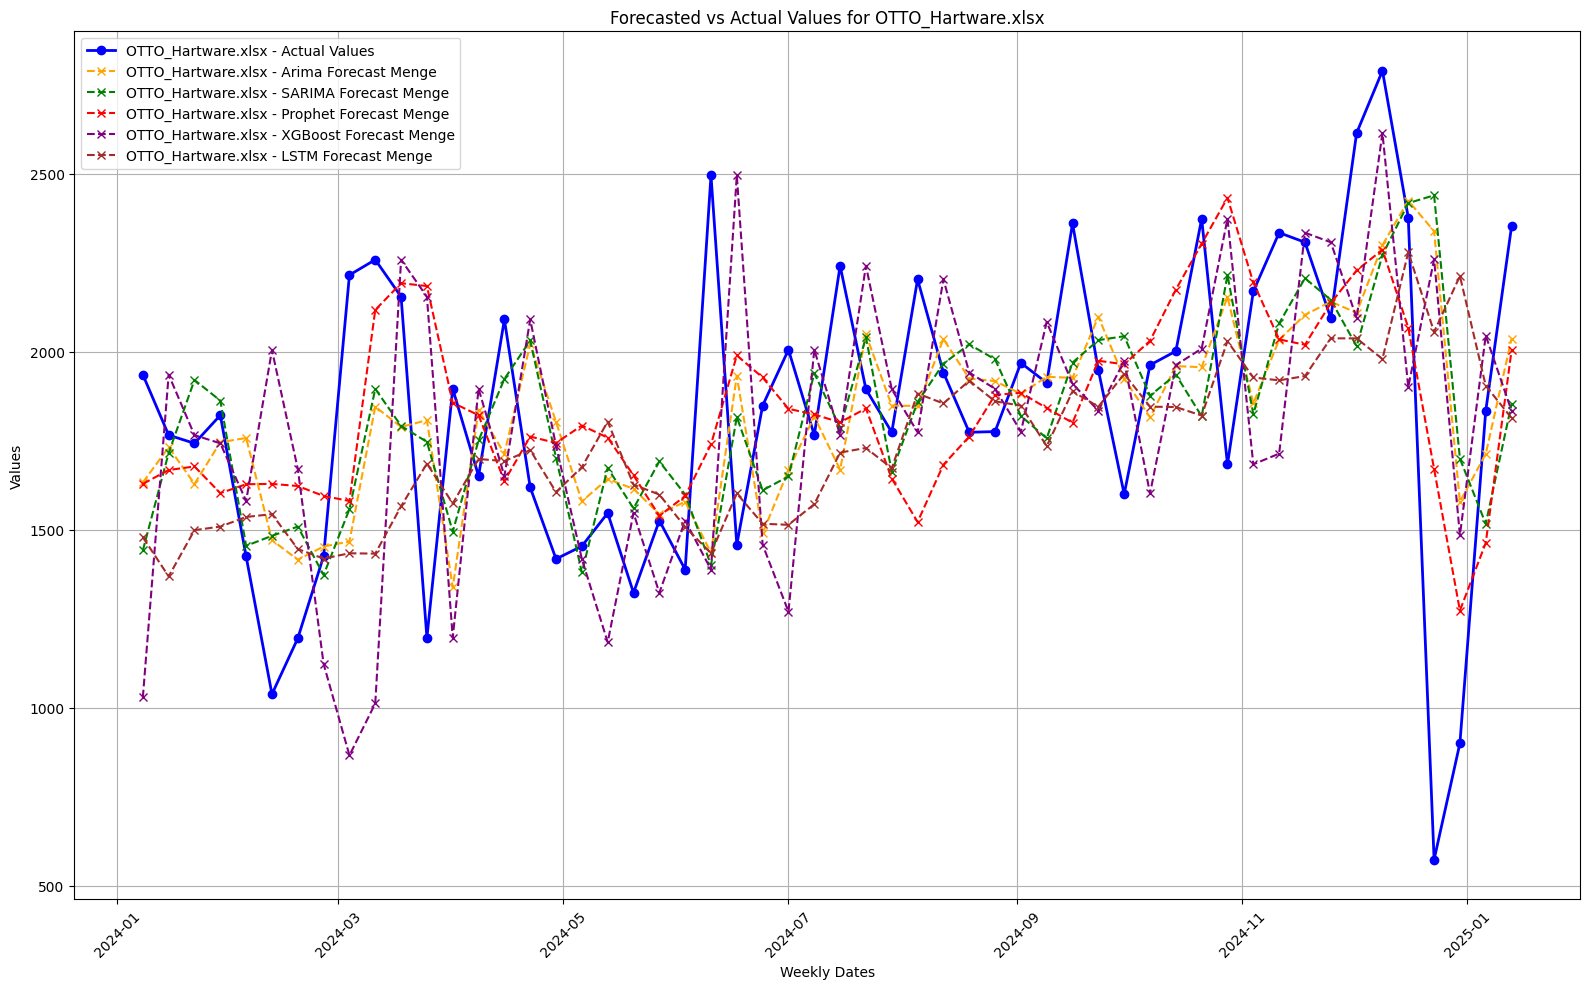

Forecasts DataFrame Info for OTTO_Schmuck.xlsx:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55 entries, 0 to 54
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   Weekly dates                54 non-null     datetime64[ns]
 1   Woche Ist Menge             55 non-null     float64       
 2   Arima Forecast Menge        54 non-null     float64       
 3   Arima Forecast Error (%)    55 non-null     int64         
 4   SARIMA Forecast Menge       54 non-null     float64       
 5   SARIMA Forecast Error (%)   55 non-null     int64         
 6   Prophet Forecast Menge      54 non-null     float64       
 7   Prophet Forecast Error (%)  55 non-null     int64         
 8   XGBoost Forecast Menge      54 non-null     float64       
 9   XGBoost Forecast Error (%)  55 non-null     int64         
 10  LSTM Forecast Menge         54 non-null     float64       
 11  LSTM Forecas

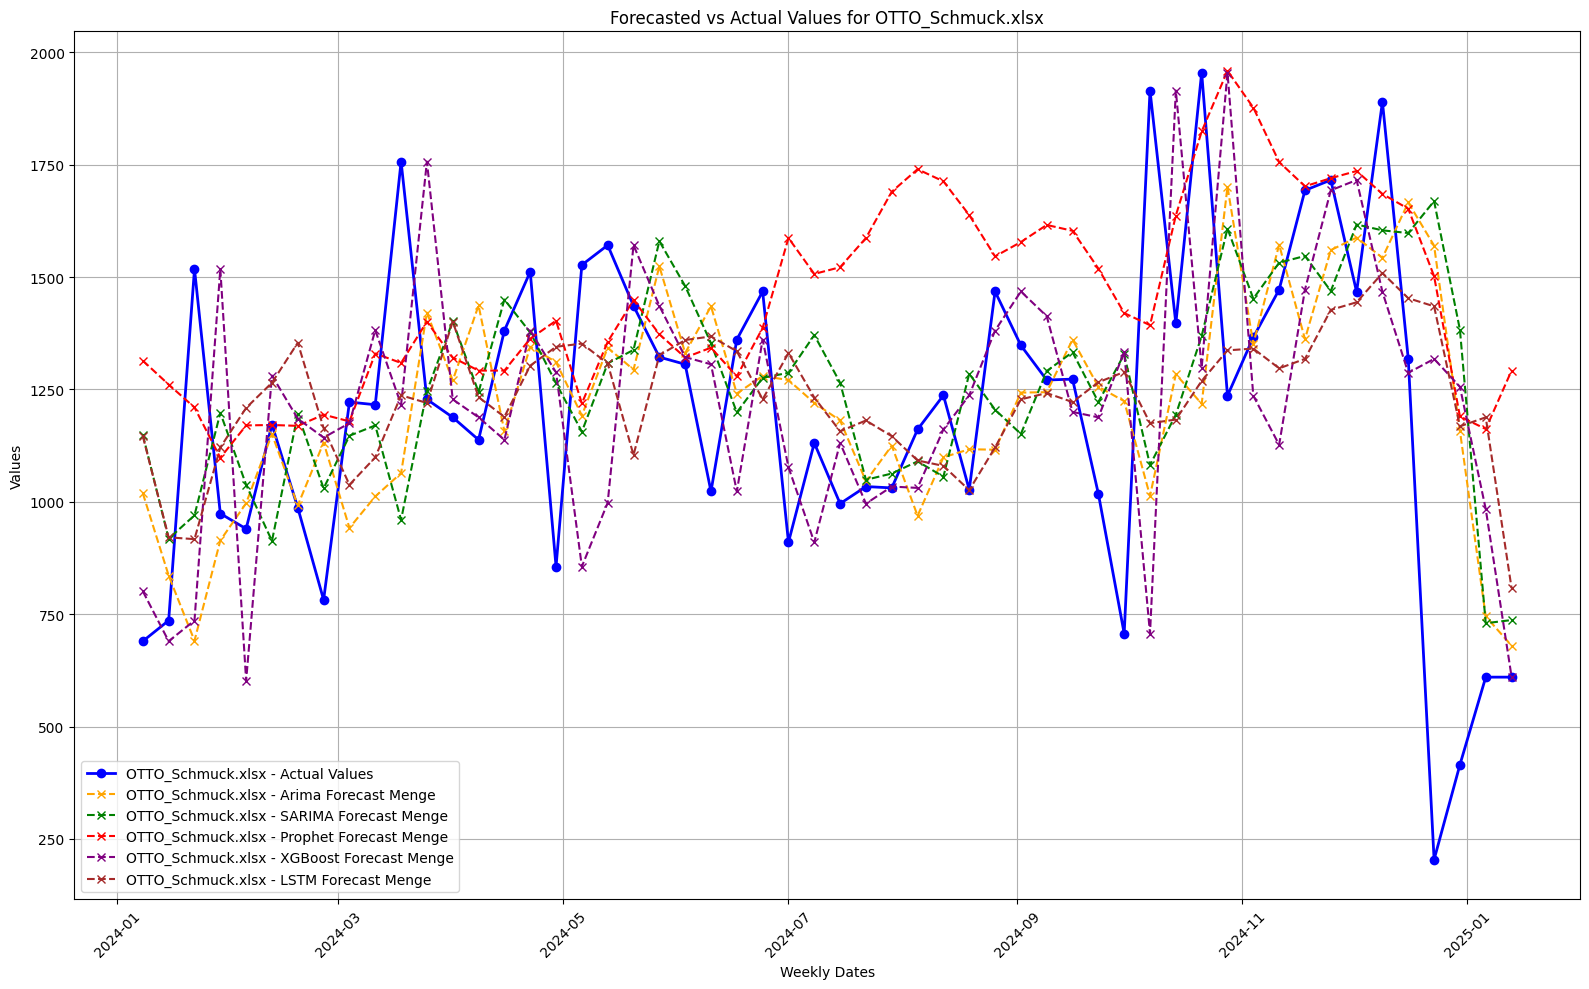

Forecasts DataFrame Info for OTTO_Schuhe.xlsx:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55 entries, 0 to 54
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   Weekly dates                54 non-null     datetime64[ns]
 1   Woche Ist Menge             55 non-null     float64       
 2   Arima Forecast Menge        54 non-null     float64       
 3   Arima Forecast Error (%)    55 non-null     int64         
 4   SARIMA Forecast Menge       54 non-null     float64       
 5   SARIMA Forecast Error (%)   55 non-null     int64         
 6   Prophet Forecast Menge      54 non-null     float64       
 7   Prophet Forecast Error (%)  55 non-null     int64         
 8   XGBoost Forecast Menge      54 non-null     float64       
 9   XGBoost Forecast Error (%)  55 non-null     int64         
 10  LSTM Forecast Menge         54 non-null     float64       
 11  LSTM Forecast

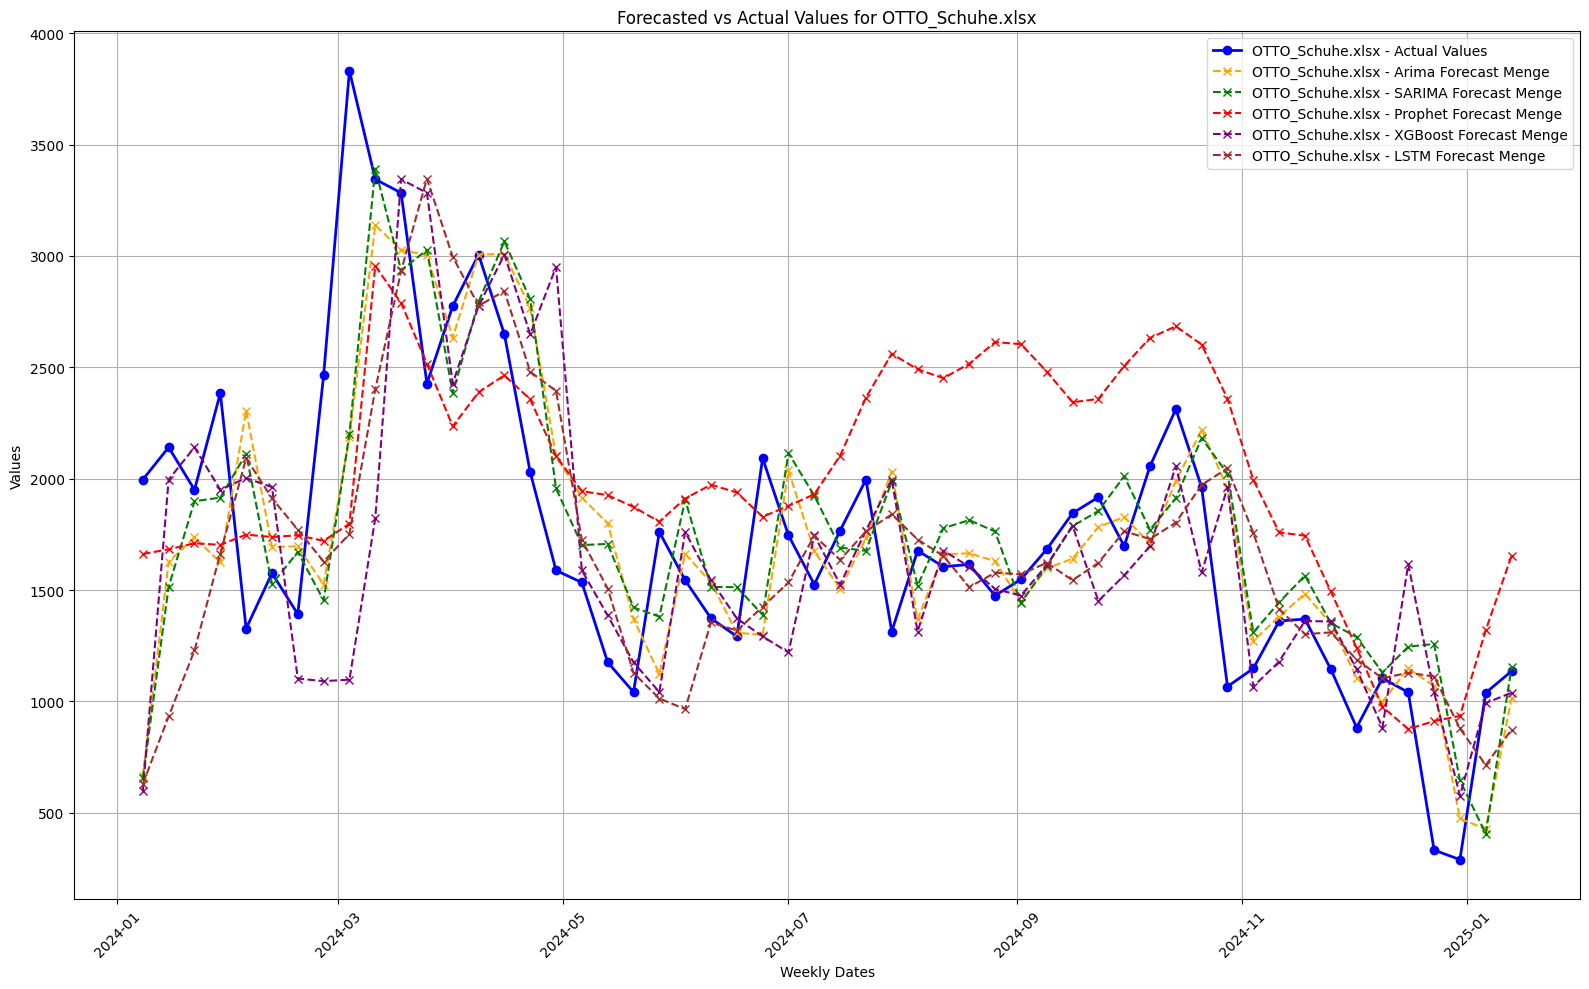

Forecasts DataFrame Info for OTTO_Textil.xlsx:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55 entries, 0 to 54
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   Weekly dates                54 non-null     datetime64[ns]
 1   Woche Ist Menge             55 non-null     float64       
 2   Arima Forecast Menge        54 non-null     float64       
 3   Arima Forecast Error (%)    55 non-null     int64         
 4   SARIMA Forecast Menge       54 non-null     float64       
 5   SARIMA Forecast Error (%)   55 non-null     int64         
 6   Prophet Forecast Menge      54 non-null     float64       
 7   Prophet Forecast Error (%)  55 non-null     int64         
 8   XGBoost Forecast Menge      54 non-null     float64       
 9   XGBoost Forecast Error (%)  55 non-null     int64         
 10  LSTM Forecast Menge         54 non-null     float64       
 11  LSTM Forecast

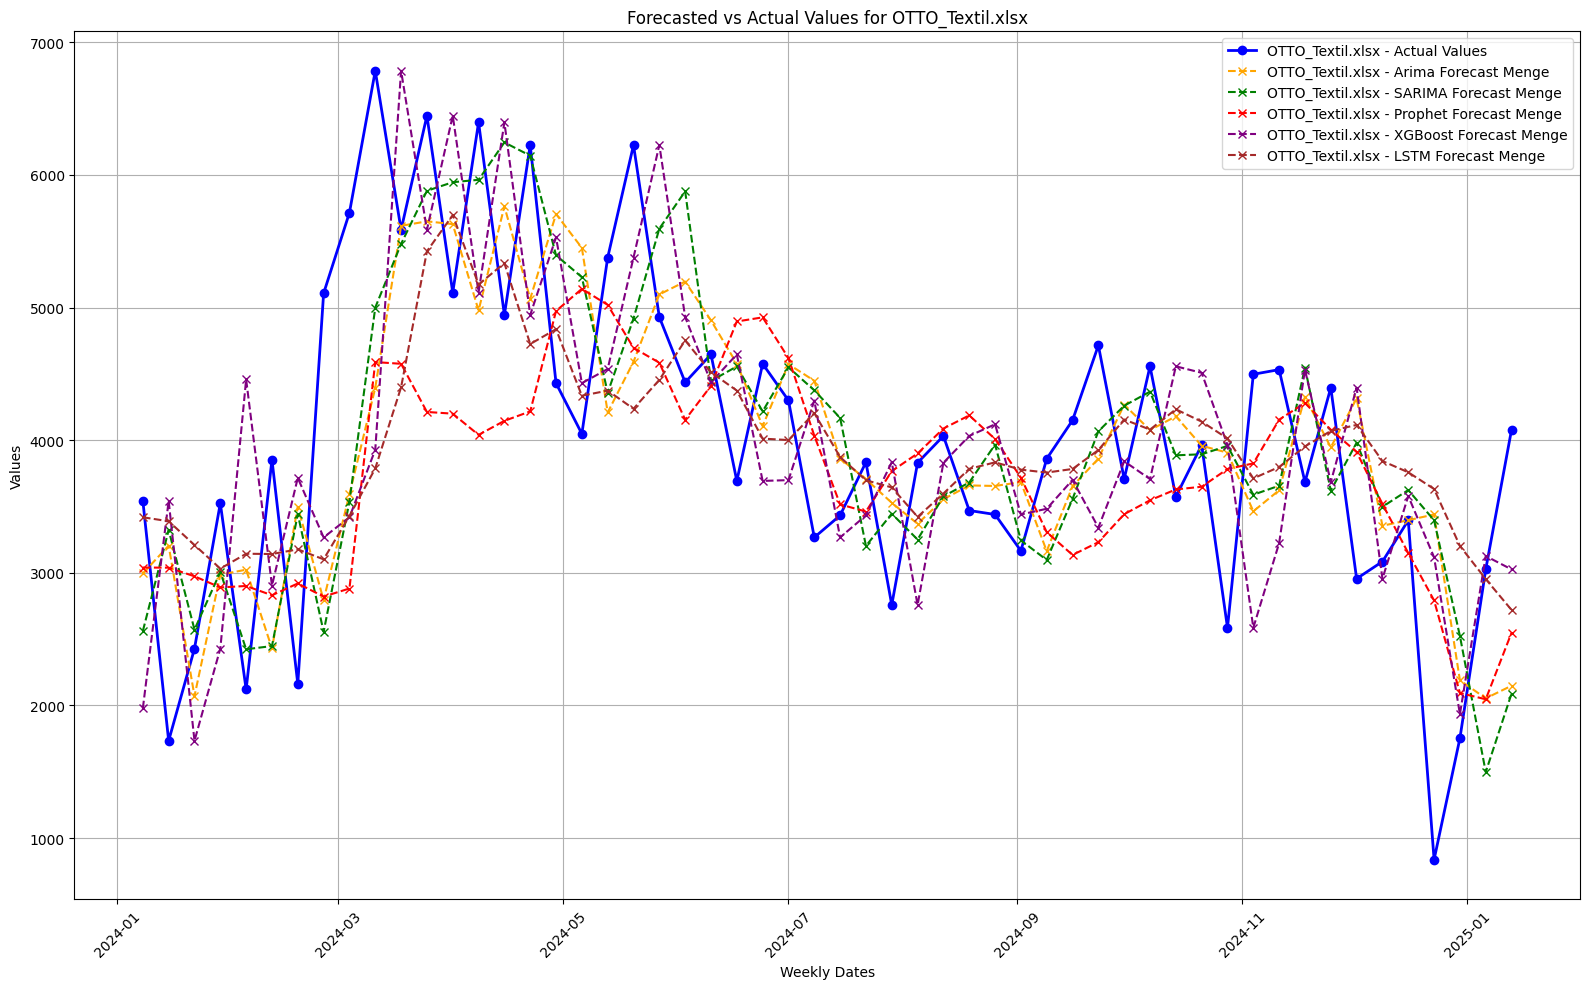

In [33]:
import os
import pandas as pd
import matplotlib.pyplot as plt

# Function to plot forecasts for each dataset in its own plot
def plot_forecasts_for_each(output_dir):
    # Get all Excel files in the output directory
    forecast_files = [f for f in os.listdir(output_dir) if f.endswith('.xlsx')]

    # Loop through each file and plot forecasts in separate plots
    for forecast_file in forecast_files:
        # Load the forecast results from Excel
        file_path = os.path.join(output_dir, forecast_file)
        forecast_results = pd.read_excel(file_path)
        
        # Handle NaN values: Interpolate, fill, or leave them as-is
        forecast_results["Woche Ist Menge"] = pd.to_numeric(
            forecast_results["Woche Ist Menge"], errors="coerce"
        ).interpolate(method="linear").fillna(0)

        forecast_results["Weekly dates"] = pd.to_datetime(forecast_results["Weekly dates"], errors="coerce")

        # Print the first few rows and column types for debugging
        print(f"Forecasts DataFrame Info for {forecast_file}:")
        print(forecast_results.info())
        print(forecast_results.head())

        # Check if 'Weekly dates' or 'Woche Ist Menge' is empty
        if forecast_results["Weekly dates"].isna().all() or forecast_results["Woche Ist Menge"].isna().all():
            print(f"Error: No valid data to plot for {forecast_file}.")
            continue  # Skip this file if data is invalid

        # Create a new plot for each dataset
        plt.figure(figsize=(16, 10))

        # Plot actual values
        plt.plot(
            forecast_results["Weekly dates"],
            forecast_results["Woche Ist Menge"],
            label=f"{forecast_file} - Actual Values",
            color="blue",
            linewidth=2,
            marker="o",
        )

        # Plot forecasted values for each model
        models = [
            ("Arima Forecast Menge", "orange"),
            ("SARIMA Forecast Menge", "green"),
            ("Prophet Forecast Menge", "red"),
            ("XGBoost Forecast Menge", "purple"),
            ("LSTM Forecast Menge", "brown"),
        ]

        for model, color in models:
            if model in forecast_results:
                forecast_results[model] = pd.to_numeric(
                    forecast_results[model], errors="coerce"
                ).interpolate(method="linear").fillna(0)

                if forecast_results[model].isna().all():
                    print(f"Skipping {model} - No valid data for {forecast_file}.")
                    continue

                plt.plot(
                    forecast_results["Weekly dates"],
                    forecast_results[model],
                    label=f"{forecast_file} - {model}",
                    color=color,
                    linewidth=1.5,
                    linestyle="--",
                    marker="x",
                )

        # Add labels, title, and legend
        plt.xlabel("Weekly Dates")
        plt.ylabel("Values")
        plt.title(f"Forecasted vs Actual Values for {forecast_file}")
        plt.legend()
        plt.grid()
        plt.xticks(rotation=45)
        plt.tight_layout()

        # Show the plot for the current dataset
        plt.show()

# Call the function to plot forecasts for each dataset
plot_forecasts_for_each(output_dir)




In [ ]:
import os
import pandas as pd
import sqlalchemy
from sqlalchemy.engine import URL

# Database Connection Parameters
mssql_server = 'hfdmmart'
mssql_database = 'TM1_SCHNITTSTELLE'
mssql_username = 'FKT_APOLLO_SPSS'
mssql_password = 'S4nKTlMRkrvkL-U3LIFbc_9Zl-Ek3f'
connection_string = f"DRIVER={{ODBC Driver 17 for SQL Server}}; SERVER={mssql_server}; DATABASE={mssql_database}; UID={mssql_username}; PWD={mssql_password}"
connection_url = URL.create("mssql+pyodbc", query={"odbc_connect": connection_string})

# Create a SQLAlchemy engine
engine = sqlalchemy.create_engine(connection_url)

# Directory for saving Excel files (optional)
output_dir = "./excel_files"
os.makedirs(output_dir, exist_ok=True)

for bdf in ['OTTO', 'BON PRIX']:
    for bereich in ['Deko', 'Hartware', 'Schmuck', 'Schuhe', 'Textil']:
        try:
            # Extract the data series for the current brand and category
            data_series = df_wp_ist_week[(bdf, bereich)].dropna()
            
            if data_series.empty:
                print(f"Skipping {bdf}, {bereich}: Data series is empty.")
                continue  # Skip if no data
            
            # Convert the series to a DataFrame with columns 'ds' and 'y'
            data_df = data_series.reset_index()
            data_df.columns = ['ds', 'y']  # Rename columns
            
            # Fetch hyperparameters for the current combination
            key = f"{bereich}_{bdf}"  
            hyperparams = best_hyperparameters_regressor_dict.get(key, {})
            
            if not hyperparams:
                print(f"No hyperparameters found for {key}. Skipping...")
                continue  
            
            # Print the transformed data frame to verify
            print(f"Transformed DataFrame for {bdf}, {bereich}:\n")
            print(data_df.head())
            
            # Generate Forecasts
            forecast_results = generate_forecasts(data_df, hyperparams)
            
            # Save the forecast results to Excel (optional)
            output_file = os.path.join(output_dir, f"{bdf}_{bereich}.xlsx")
            forecast_results.to_excel(output_file, index=False)
            print(f"Generated: {output_file}")
            
            # Write the forecast results back to SQL Server
            forecast_results['Brand'] = bdf
            forecast_results['Category'] = bereich
            
            # Specify table name in SQL
            table_name = 'ForecastResults'  # Replace with your SQL table name
            
            # Insert data into SQL table
            forecast_results.to_sql(
                table_name, 
                con=engine, 
                if_exists='append',  # Append to existing table
                index=False
            )
            print(f"Data for {bdf}, {bereich} written to SQL table '{table_name}'.")
        
        except Exception as e:
            print(f"Error processing {bdf}, {bereich}: {e}")
